This notebook explores how to extract features from oriented 3D brains and tumor masks.
We are using [this radiomic feature library](https://pyradiomics.readthedocs.io/en/latest/index.html).

In [1]:
import glob
import os
import random
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage
import math
from tqdm.auto import tqdm
import SimpleITK as sitk
import radiomics

In [2]:
df = pd.read_csv('../input/train_labels_folds-v1.csv')
df.head()

BraTS21ID  MGMT_value  fold
0          0           1     2
1          2           1     2
2          3           0     1
3          5           1     2
4          6           1     0

In [3]:
REG_DIR = '../input/registered_cases/train/'
SEG_DIR = '../output/OOF_segmentations_256/'

In [6]:
bratsid = f'{int(df.BraTS21ID.values[0]):05d}'
reg_fn = os.path.join(REG_DIR, f'{bratsid}.npy')
seg_fn = os.path.join(SEG_DIR, f'{bratsid}_seg.npy')
reg_arr = np.load(reg_fn)
seg_arr = np.load(seg_fn)

reg_arr = reg_arr.swapaxes(0,3)
# crop reg_arr to match mask
reg_arr = reg_arr[:,:,:,:96]
reg_arr.shape, seg_arr.shape

((3, 256, 256, 96), (1, 256, 256, 96))

In [7]:
reg = sitk.GetImageFromArray(reg_arr[0])
seg = sitk.GetImageFromArray(np.array(seg_arr > 0.5).astype(np.uint8)[0])

In [14]:
%%time

def _get_shape_features(reg, seg, feats):
    """ Tumor shape descriptors """
    try:
        shape = radiomics.shape.RadiomicsShape(reg, seg)
        feats['mesh_volume'] = shape.getMeshVolumeFeatureValue()
        feats['surface_area'] = shape.getSurfaceAreaFeatureValue()
        feats['surface_volume_ratio'] = shape.getSurfaceVolumeRatioFeatureValue()
        feats['sphericity'] = shape.getSphericityFeatureValue()
        feats['spherical_disproportion'] = shape.getSphericalDisproportionFeatureValue()
        feats['maximum_3d_diameter'] = shape.getMaximum3DDiameterFeatureValue()
        feats['maximum_2d_diameter_slice'] = shape.getMaximum2DDiameterSliceFeatureValue()
        feats['maximum_2d_diameter_column'] = shape.getMaximum2DDiameterColumnFeatureValue()
        feats['maximum_2d_diameter_row'] = shape.getMaximum2DDiameterRowFeatureValue()
        feats['major_axis_length'] = shape.getMajorAxisLengthFeatureValue()
        feats['minor_axis_length'] = shape.getMinorAxisLengthFeatureValue()
        feats['least_axis_length'] = shape.getLeastAxisLengthFeatureValue()
        feats['elongation'] = shape.getElongationFeatureValue()
        feats['flatness'] = shape.getFlatnessFeatureValue()
    except: 
        feats['mesh_volume'] = 0
        feats['surface_area'] = 0
        feats['surface_volume_ratio'] = 0
        feats['sphericity'] = 0
        feats['spherical_disproportion'] = 0
        feats['maximum_3d_diameter'] = 0
        feats['maximum_2d_diameter_slice'] = 0
        feats['maximum_2d_diameter_column'] = 0
        feats['maximum_2d_diameter_row'] = 0
        feats['major_axis_length'] = 0
        feats['minor_axis_length'] = 0
        feats['least_axis_length'] = 0
        feats['elongation'] = 0
        feats['flatness'] = 0
    
def _get_firstorder_features(reg, seg, channel, feats):
    """ Tumor voxel intensity statistics """
    try:
        firstorder = radiomics.firstorder.RadiomicsFirstOrder(reg,seg)
        firstorder._initCalculation()
        feats[f'energy_{channel}'] = firstorder.getEnergyFeatureValue()[0]
        feats[f'total_energy_{channel}'] = firstorder.getTotalEnergyFeatureValue()[0]
        feats[f'entropy_{channel}'] = firstorder.getEntropyFeatureValue()[0]
        feats[f'minimum_{channel}'] = firstorder.getMinimumFeatureValue()[0]
        feats[f'10percentile_{channel}'] = firstorder.get10PercentileFeatureValue()[0]
        feats[f'90percentile_{channel}'] = firstorder.get90PercentileFeatureValue()[0]
        feats[f'maximum_{channel}'] = firstorder.getMaximumFeatureValue()[0]
        feats[f'mean_{channel}'] = firstorder.getMeanFeatureValue()[0]
        feats[f'median_{channel}'] = firstorder.getMedianFeatureValue()[0]
        feats[f'mean_abs_dev_{channel}'] = firstorder.getMeanAbsoluteDeviationFeatureValue()[0]
        feats[f'robust_mean_abs_dev_{channel}'] = firstorder.getRobustMeanAbsoluteDeviationFeatureValue()[0]
        feats[f'skewness_{channel}'] = firstorder.getSkewnessFeatureValue()[0]
        feats[f'kurtosis_{channel}'] = firstorder.getKurtosisFeatureValue()[0]
        feats[f'uniformity_{channel}'] = firstorder.getUniformityFeatureValue()[0]
    except:
        feats[f'energy_{channel}'] = 0
        feats[f'total_energy_{channel}'] = 0
        feats[f'entropy_{channel}'] = 0
        feats[f'minimum_{channel}'] = 0
        feats[f'10percentile_{channel}'] = 0
        feats[f'90percentile_{channel}'] = 0
        feats[f'maximum_{channel}'] = 0
        feats[f'mean_{channel}'] = 0
        feats[f'median_{channel}'] = 0
        feats[f'mean_abs_dev_{channel}'] = 0
        feats[f'robust_mean_abs_dev_{channel}'] = 0
        feats[f'skewness_{channel}'] = 0
        feats[f'kurtosis_{channel}'] = 0
        feats[f'uniformity_{channel}'] = 0
    
def _get_glcm_features(reg, seg, channel, feats):
    """ Gray level co-occurence matrix features """
    try:
        glcm = radiomics.glcm.RadiomicsGLCM(reg,seg)
        glcm._initCalculation()
        feats[f'autocorrelation_{channel}'] = glcm.getAutocorrelationFeatureValue()[0]
        feats[f'joint_avg_{channel}'] = glcm.getJointAverageFeatureValue()[0]
        feats[f'contrast_{channel}'] = glcm.getContrastFeatureValue()[0]
        feats[f'cluster_prominence_{channel}'] = glcm.getClusterProminenceFeatureValue()[0]
        feats[f'cluster_shade_{channel}'] = glcm.getClusterShadeFeatureValue()[0]
        feats[f'cluster_tendency_{channel}'] = glcm.getClusterTendencyFeatureValue()[0]
        feats[f'correlation_{channel}'] = glcm.getCorrelationFeatureValue()[0]
        feats[f'difference_average_{channel}'] = glcm.getDifferenceAverageFeatureValue()[0]
        feats[f'difference_entropy_{channel}'] = glcm.getDifferenceEntropyFeatureValue()[0]
        feats[f'difference_variance_{channel}'] = glcm.getDifferenceVarianceFeatureValue()[0]
        feats[f'joint_energy_{channel}'] = glcm.getJointEnergyFeatureValue()[0]
        feats[f'joint_entropy_{channel}'] = glcm.getJointEntropyFeatureValue()[0]
    except:
        feats[f'autocorrelation_{channel}'] = 0
        feats[f'joint_avg_{channel}'] = 0
        feats[f'contrast_{channel}'] = 0
        feats[f'cluster_prominence_{channel}'] = 0
        feats[f'cluster_shade_{channel}'] = 0
        feats[f'cluster_tendency_{channel}'] = 0
        feats[f'correlation_{channel}'] = 0
        feats[f'difference_average_{channel}'] = 0
        feats[f'difference_entropy_{channel}'] = 0
        feats[f'difference_variance_{channel}'] = 0
        feats[f'joint_energy_{channel}'] = 0
        feats[f'joint_entropy_{channel}'] = 0
    
def _get_position_features(seg_arr, feats):
    """ Tumor position stats """
    try:
        nonzero_coords = np.argwhere(seg_arr > 0)
        for axis in range(3):
            axis_coords = nonzero_coords[:,axis]
            feats[f'minimum_ax_{axis}'] = np.min(axis_coords)
            feats[f'percentile10_ax_{axis}'] = np.percentile(axis_coords, 10)
            feats[f'mean_ax_{axis}'] = np.mean(axis_coords)
            feats[f'median_ax_{axis}'] = np.median(axis_coords)
            feats[f'percentile90_ax_{axis}'] = np.percentile(axis_coords, 90)
            feats[f'maximum_ax_{axis}'] = np.max(axis_coords)
    except:
        for axis in range(3):
            feats[f'minimum_ax_{axis}'] = 0
            feats[f'percentile10_ax_{axis}'] = 0
            feats[f'mean_ax_{axis}'] = 0
            feats[f'median_ax_{axis}'] = 0
            feats[f'percentile90_ax_{axis}'] = 0
            feats[f'maximum_ax_{axis}'] = 0

def get_radiomics_features(reg_fn, seg_fn):
    """ Returns a dictionary of features """
    feats = {'BraTS21ID' : os.path.basename(reg_fn).split('.')[0]}
    
    reg_arr = np.load(reg_fn)
    seg_arr = np.load(seg_fn)
    reg_arr = reg_arr.swapaxes(0,3)
    # crop reg arr to match seg shape - seg was predicted with cropped images
    reg_arr = reg_arr[:,:,:,:96]
    seg_arr = np.array(seg_arr > 0.5).astype(np.uint8)[0]
    seg = sitk.GetImageFromArray(seg_arr)
    regs = [sitk.GetImageFromArray((reg_arr[channel] * 255).astype(np.uint8)) for channel in range(3)]
    
    # Shape features
    _get_shape_features(regs[0], seg, feats)
    
    # Firstorder statistics features for all channels
    for channel in range(3):
        _get_firstorder_features(regs[channel], seg, channel, feats)
        
    # GLCM features
    for channel in range(3):
        _get_glcm_features(regs[channel], seg, channel, feats)
        
    # Position features
    _get_position_features(seg_arr, feats)
    
    return feats
    
get_radiomics_features(reg_fn, seg_fn)

CPU times: user 299 ms, sys: 292 ms, total: 592 ms
Wall time: 588 ms


{'BraTS21ID': '00113',
 'mesh_volume': 0,
 'surface_area': 0,
 'surface_volume_ratio': 0,
 'sphericity': 0,
 'spherical_disproportion': 0,
 'maximum_3d_diameter': 0,
 'maximum_2d_diameter_slice': 0,
 'maximum_2d_diameter_column': 0,
 'maximum_2d_diameter_row': 0,
 'major_axis_length': 0,
 'minor_axis_length': 0,
 'least_axis_length': 0,
 'elongation': 0,
 'flatness': 0,
 'energy_0': 0,
 'total_energy_0': 0,
 'entropy_0': 0,
 'minimum_0': 0,
 '10percentile_0': 0,
 '90percentile_0': 0,
 'maximum_0': 0,
 'mean_0': 0,
 'median_0': 0,
 'mean_abs_dev_0': 0,
 'robust_mean_abs_dev_0': 0,
 'skewness_0': 0,
 'kurtosis_0': 0,
 'uniformity_0': 0,
 'energy_1': 0,
 'total_energy_1': 0,
 'entropy_1': 0,
 'minimum_1': 0,
 '10percentile_1': 0,
 '90percentile_1': 0,
 'maximum_1': 0,
 'mean_1': 0,
 'median_1': 0,
 'mean_abs_dev_1': 0,
 'robust_mean_abs_dev_1': 0,
 'skewness_1': 0,
 'kurtosis_1': 0,
 'uniformity_1': 0,
 'energy_2': 0,
 'total_energy_2': 0,
 'entropy_2': 0,
 'minimum_2': 0,
 '10percentile_

### Collect and save features

In [15]:
feature_dicts = []

for _id in tqdm(df.BraTS21ID.values):
    bratsid = f'{int(_id):05d}'
    reg_fn = os.path.join(REG_DIR, f'{bratsid}.npy')
    seg_fn = os.path.join(SEG_DIR, f'{bratsid}_seg.npy')
    if os.path.exists(reg_fn) and os.path.exists(seg_fn):
        feature_dicts.append(get_radiomics_features(reg_fn, seg_fn))

  0%|          | 0/585 [00:00<?, ?it/s]

In [16]:
df_feature = pd.DataFrame(feature_dicts)
df_feature['BraTS21ID'] = [int(val) for val in df_feature['BraTS21ID'].values]
df_all = pd.merge(df, df_feature, on='BraTS21ID')
df_all.head()

BraTS21ID  MGMT_value  fold    mesh_volume  surface_area  \
0          0           1     2  159374.833333  20741.269121   
1          2           1     2  196020.500000  26098.518115   
2          3           0     1  227281.125000  24005.453200   
3          5           1     2  278976.750000  31507.001329   
4          6           1     0  307876.916667  30149.226650   

   surface_volume_ratio  sphericity  spherical_disproportion  \
0              0.130141    0.685376                 1.459054   
1              0.133142    0.625272                 1.599303   
2              0.105620    0.750268                 1.332857   
3              0.112938    0.655323                 1.525964   
4              0.097926    0.731351                 1.367332   

   maximum_3d_diameter  maximum_2d_diameter_slice  ...   mean_ax_1  \
0           237.766692                  89.274856  ...  165.275800   
1           135.417872                  86.052310  ...  177.636621   
2           115.047816                 106.230881  ...  158.150338   
3           171.642069                 105.574618  ...  170.655096   
4           140.484875                 130.138388  ...  141.050640   

   median_ax_1  percentile90_ax_1  maximum_ax_1  minimum_ax_2  \
0        165.0              194.0           211            25   
1        178.0              205.0           220            32   
2        158.0              190.0           213            49   
3        169.0              206.0           229            33   
4        139.0              181.0           212            34   

   percentile10_ax_2  mean_ax_2  median_ax_2  percentile90_ax_2  maximum_ax_2  
0               31.0  41.037986         41.0               51.0            59  
1               41.0  55.660076         55.0               70.0            79  
2               62.0  74.993091         75.0               88.0            95  
3               55.0  67.263955         67.0               80.0            91  
4               42.0  55.577350         55.0               71.0            83  

[5 rows x 113 columns]

In [17]:
df_all.describe()

BraTS21ID  MGMT_value        fold   mesh_volume   surface_area  \
count   577.000000  577.000000  577.000000  5.770000e+02     577.000000   
mean    430.774697    0.521664    1.982669  2.363009e+05   28486.324843   
std     251.066900    0.499964    1.414107  1.197830e+05   11234.722498   
min       0.000000    0.000000    0.000000  0.000000e+00       0.000000   
25%     219.000000    0.000000    1.000000  1.492674e+05   21656.071066   
50%     425.000000    1.000000    2.000000  2.268719e+05   27860.065757   
75%     630.000000    1.000000    3.000000  3.128447e+05   34657.926351   
max    1010.000000    1.000000    4.000000  1.041537e+06  108808.644483   

       surface_volume_ratio  sphericity  spherical_disproportion  \
count            577.000000  577.000000               577.000000   
mean               0.135788    0.634554                 1.589141   
std                0.056536    0.092734                 0.265088   
min                0.000000    0.000000                 0.000000   
25%                0.108347    0.589992                 1.440776   
50%                0.122406    0.655349                 1.525317   
75%                0.146729    0.692971                 1.692133   
max                0.789067    0.793367                 2.854486   

       maximum_3d_diameter  maximum_2d_diameter_slice  ...   mean_ax_1  \
count           577.000000                 577.000000  ...  577.000000   
mean            149.094539                 114.561954  ...  128.094159   
std              39.262898                  31.256842  ...   55.525470   
min               0.000000                   0.000000  ...    0.000000   
25%             122.776219                  94.191295  ...   78.088668   
50%             144.267113                 109.457754  ...  121.956014   
75%             171.642069                 130.096118  ...  183.100824   
max             360.939053                 268.508845  ...  230.065500   

       median_ax_1  percentile90_ax_1  maximum_ax_1  minimum_ax_2  \
count   577.000000         577.000000    577.000000    577.000000   
mean    128.285962         161.775043    188.206239     28.327556   
std      56.302041          56.256883     53.902118     14.652875   
min       0.000000           0.000000      0.000000      0.000000   
25%      77.000000         110.000000    138.000000     17.000000   
50%     122.000000         172.000000    202.000000     27.000000   
75%     183.000000         216.000000    238.000000     40.000000   
max     230.000000         247.000000    255.000000     74.000000   

       percentile10_ax_2   mean_ax_2  median_ax_2  percentile90_ax_2  \
count         577.000000  577.000000   577.000000         577.000000   
mean           40.097054   53.876774    53.828423          67.760832   
std            14.256612   13.915145    14.235617          14.489639   
min             0.000000    0.000000     0.000000           0.000000   
25%            29.000000   43.828161    44.000000          58.000000   
50%            40.000000   53.589929    54.000000          68.000000   
75%            51.000000   64.323649    64.000000          79.000000   
max            80.000000   87.042721    90.000000          95.000000   

       maximum_ax_2  
count    577.000000  
mean      78.381282  
std       14.370961  
min        0.000000  
25%       69.000000  
50%       80.000000  
75%       91.000000  
max       95.000000  

[8 rows x 113 columns]

In [18]:
df_all.to_csv('../input/train_feature_data_v2.csv')

## Checkpoint

In [19]:
df_all = pd.read_csv('../input/train_feature_data_v2.csv')
df_all.head()

Unnamed: 0  BraTS21ID  MGMT_value  fold    mesh_volume  surface_area  \
0           0          0           1     2  159374.833333  20741.269121   
1           1          2           1     2  196020.500000  26098.518115   
2           2          3           0     1  227281.125000  24005.453200   
3           3          5           1     2  278976.750000  31507.001329   
4           4          6           1     0  307876.916667  30149.226650   

   surface_volume_ratio  sphericity  spherical_disproportion  \
0              0.130141    0.685376                 1.459054   
1              0.133142    0.625272                 1.599303   
2              0.105620    0.750268                 1.332857   
3              0.112938    0.655323                 1.525964   
4              0.097926    0.731351                 1.367332   

   maximum_3d_diameter  ...   mean_ax_1  median_ax_1  percentile90_ax_1  \
0           237.766692  ...  165.275800        165.0              194.0   
1           135.417872  ...  177.636621        178.0              205.0   
2           115.047816  ...  158.150338        158.0              190.0   
3           171.642069  ...  170.655096        169.0              206.0   
4           140.484875  ...  141.050640        139.0              181.0   

   maximum_ax_1  minimum_ax_2  percentile10_ax_2  mean_ax_2  median_ax_2  \
0           211            25               31.0  41.037986         41.0   
1           220            32               41.0  55.660076         55.0   
2           213            49               62.0  74.993091         75.0   
3           229            33               55.0  67.263955         67.0   
4           212            34               42.0  55.577350         55.0   

   percentile90_ax_2  maximum_ax_2  
0               51.0            59  
1               70.0            79  
2               88.0            95  
3               80.0            91  
4               71.0            83  

[5 rows x 114 columns]

## Feature model

In [20]:
import xgboost as xgb
from sklearn import linear_model
import optuna
import seaborn as sns

In [21]:
all_feat_names = df_all.columns.to_list()[4:]
corr = df_all[['MGMT_value'] + all_feat_names].corr()

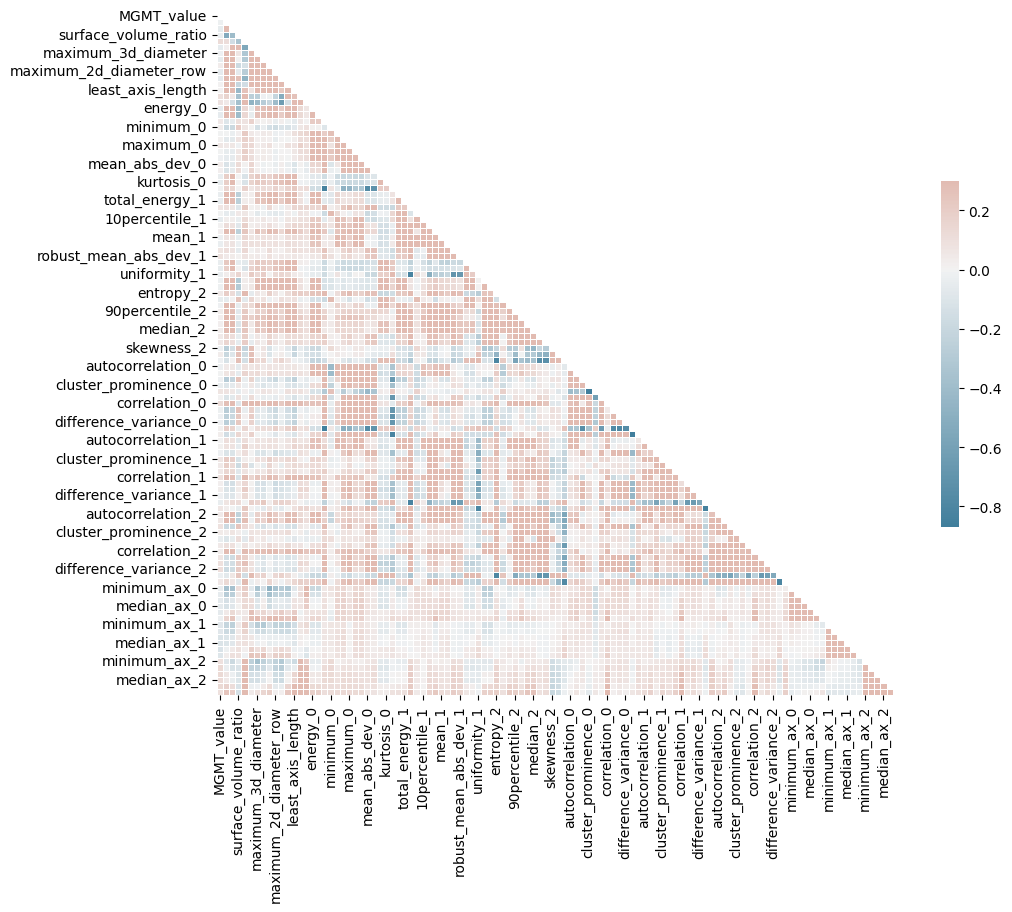

In [22]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.close('all')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [24]:
mgmt_corr_sorted = corr['MGMT_value'].sort_values()
mgmt_corr_sorted[:5], mgmt_corr_sorted[-6:-1]

(percentile90_ax_1   -0.115617
 median_ax_1         -0.107567
 mean_ax_1           -0.103234
 maximum_ax_1        -0.090067
 percentile10_ax_1   -0.082246
 Name: MGMT_value, dtype: float64,
 correlation_0        0.119817
 median_ax_2          0.126024
 percentile10_ax_2    0.126604
 percentile90_ax_2    0.127253
 mean_ax_2            0.128695
 Name: MGMT_value, dtype: float64)

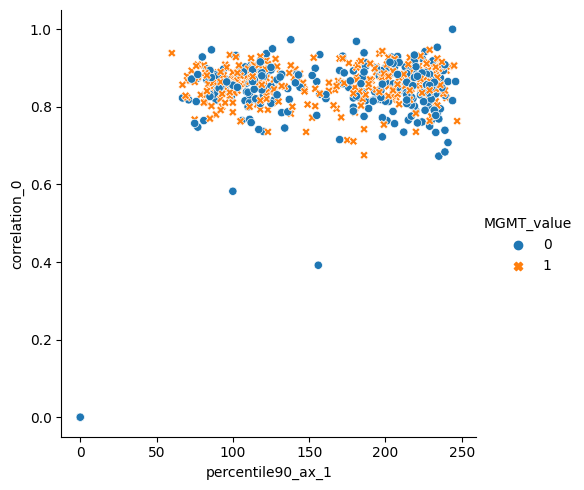

In [25]:
sns.relplot(x='percentile90_ax_1', y="correlation_0", hue="MGMT_value", style="MGMT_value", data=df_all)
plt.show()

In [60]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

def get_data(fold, features):
    df = df_all.dropna(inplace=False)
    scaler = StandardScaler()
    
    df_train = df[df.fold != fold]
    df_val = df[df.fold == fold]
    if len(df_val) == 0:
        df_val = df[df.fold == 0]
    
    # shuffle train
    df_train = df_train.sample(frac=1)
    
    y_train = df_train.MGMT_value.to_numpy().reshape((-1,1)).astype(np.float32)
    y_val = df_val.MGMT_value.to_numpy().reshape((-1,1)).astype(np.float32)
    
    X_train = df_train[features].to_numpy().astype(np.float32)
    X_val = df_val[features].to_numpy().astype(np.float32)
    
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    return X_train, y_train, X_val, y_val, scaler

def measure_cv_score(parameters, verbose=False, train_one_model=False, plot=False, return_oof_preds=False):
    
    val_preds = []
    val_gts = []
    val_aucs = []
    val_accs = []
    
    for fold in range(5):
        
        if train_one_model: fold = -1
        
        X_train, y_train, X_val, y_val, scaler = get_data(fold, features=parameters['features'])
        
        if parameters['model_type'] == 'xgb':
            model = xgb.XGBRegressor(
                    n_estimators=parameters['n_estimators'], 
                    max_depth=parameters['max_depth'], 
                    eta=parameters['eta'],
                    subsample=parameters['subsample'], 
                    colsample_bytree=parameters['colsample_bytree'],
                    gamma=parameters['gamma']
                )
        elif parameters['model_type'] == 'linreg':
            model = linear_model.LinearRegression()
        elif parameters['model_type'] == 'ridge':
            model = linear_model.Ridge(parameters['alpha'])
        elif parameters['model_type'] == 'bayesian':
            model = linear_model.BayesianRidge(
                n_iter = parameters['n_iter'],
                lambda_1 = parameters['lambda_1'],
                lambda_2 = parameters['lambda_2'],
                alpha_1 = parameters['alpha_1'],
                alpha_2 = parameters['alpha_2'],
            )
        elif parameters['model_type'] == 'logreg':
            model = linear_model.LogisticRegression()
        elif parameters['model_type'] == 'lassolarsic':
            model = linear_model.LassoLarsIC(
                max_iter = parameters['max_iter'],
                eps = parameters['eps']
            )
        elif parameters['model_type'] == 'perceptron':
            model = linear_model.Perceptron(
            )
        else:
            raise NotImplementedError
        
        model.fit(X_train, y_train.ravel())
        
        if train_one_model:
            return model, scaler
        
        val_pred = model.predict(X_val)
        val_preds += list(val_pred)
        val_gts += list(y_val)
        val_aucs.append(roc_auc_score(np.array(y_val).flatten().astype(np.float32), np.array(val_pred).flatten()))
        val_accs.append(accuracy_score((np.array(y_val) > 0.5).flatten(), (np.array(val_pred) > 0.5).flatten()))
    
    if return_oof_preds:
        return np.array(val_preds).flatten(), np.array(val_gts).flatten()
    
    oof_acc = accuracy_score((np.array(val_gts) > 0.5).flatten(), (np.array(val_preds) > 0.5).flatten())
    oof_auc = roc_auc_score(np.array(val_gts).flatten().astype(np.float32), np.array(val_preds).flatten())
    auc_std = np.std(np.array(val_aucs))
    
    if plot:
        df_plot = pd.DataFrame({'Pred-MGMT': np.array(val_preds).flatten(), 'GT-MGMT': np.array(val_gts).flatten()})
        sns.histplot(x='Pred-MGMT', hue='GT-MGMT', data=df_plot)
        plt.title(f'{parameters["model_type"]} # CV AUC = {oof_auc:.3f} (std {auc_std:.3f}), Acc. = {oof_acc:.3f}')
        plt.show()
    
    if verbose:
        print(f'CV AUC = {oof_auc} (std {auc_std}), Acc. = {oof_acc}, aucs: {val_aucs}, accs: {val_accs}')
    
    # optimize lower limit of the (2x std range around mean)
    # This way, we choose the model which ranks well and performs ~equally well on all folds
    return float(oof_auc) - auc_std

In [27]:
default_parameters = {
    'model_type': 'lassolarsic',
    'n_estimators': 1000,
    'max_depth' : 3,
    'eta': 0.12,
    'subsample': 0.7,
    'colsample_bytree' : 0.8,
    'gamma' : 1.0,
    'alpha' : 1.0,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : all_feat_names
}
measure_cv_score(default_parameters, verbose=True)

CV AUC = 0.5574654533198518 (std 0.03000806849555598), Acc. = 0.5355285961871751, aucs: [0.5167155425219941, 0.5460410557184752, 0.6083535108958839, 0.5654545454545454, 0.5498432601880877], accs: [0.5299145299145299, 0.5641025641025641, 0.5739130434782609, 0.5217391304347826, 0.48672566371681414]


/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=3.672e-04, previous alpha=3.669e-04, with an active set of 29 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


0.5274573848242958

In [28]:
def feat_selection_objective(trial):
    kept_feats = []
    for i in range(len(all_feat_names)):
        var = trial.suggest_int(all_feat_names[i], 0,1)
        if var == 1:
            kept_feats.append(all_feat_names[i])
    parameters = default_parameters.copy()
    parameters['features'] = kept_feats
    
    return 1 - measure_cv_score(parameters, verbose=False)

if 1:
    study = optuna.create_study()
    study.optimize(feat_selection_objective, n_trials=1000, show_progress_bar=True)
    print(study.best_value, study.best_params)

[I 2021-09-25 12:03:57,437] A new study created in memory with name: no-name-38af7758-d83f-4f89-b90e-bec8f7c6b6f1
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=1.561e-03, previous alpha=1.561e-03, with an active set of 5 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:03:57,684] Trial 0 finished with value: 0.4734467550810336 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'minimu

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=7.901e-04, previous alpha=7.598e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:03:58,101] Trial 2 finished with value: 0.45475234127690756 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 47 iterations, alpha=8.765e-05, previous alpha=7.489e-05, with an active set of 46 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=1.219e-03, previous alpha=1.219e-03, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:03:58,516] Trial 4 finished with value: 0.46506668130239903 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=1.870e-04, previous alpha=1.845e-04, with an active set of 35 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:03:59,311] Trial 8 finished with value: 0.4654005630320581 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minimu

[I 2021-09-25 12:04:01,072] Trial 12 finished with value: 0.44478659090174144 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 12:04:03,204] Trial 16 finished with value: 0.4490276813034232 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=1.334e-03, previous alpha=1.322e-03, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:04:03,781] Trial 17 finished with value: 0.4667769381182907 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=2.613e-04, previous alpha=2.591e-04, with an active set of 25 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 41 iterations, alpha=1.614e-04, previous alpha=1.612e-04, with an active set of 36 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:04:04,839] Trial 19 finished with value: 0.46461089299834224 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 12:04:07,028] Trial 23 finished with value: 0.44478659090174144 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=1.675e-03, previous alpha=1.669e-03, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=1.116e-03, previous alpha=1.081e-03, with an active set of 16 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curren

[I 2021-09-25 12:04:08,605] Trial 26 finished with value: 0.45871956185774854 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 44 iterations, alpha=6.798e-05, previous alpha=6.782e-05, with an active set of 39 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=5.703e-04, previous alpha=5.400e-04, with an active set of 18 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-25 12:04:09,645] Trial 28 finished with value: 0.43290163951571103 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=9.930e-04, previous alpha=9.749e-04, with an active set of 16 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iterations, alpha=1.403e-03, previous alpha=1.368e-03, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-25 12:04:10,196] Trial 29 finished with value: 0.467677917842409 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'minimu

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 47 iterations, alpha=6.639e-05, previous alpha=6.433e-05, with an active set of 38 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 41 iterations, alpha=1.062e-04, previous alpha=1.061e-04, with an active set of 36 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:04:10,714] Trial 30 finished with value: 0.4565590783419943 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=4.999e-04, previous alpha=4.641e-04, with an active set of 22 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=1.219e-03, previous alpha=1.219e-03, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:04:11,851] Trial 32 finished with value: 0.46419967744793134 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=1.297e-03, previous alpha=1.219e-03, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:04:12,372] Trial 33 finished with value: 0.4604848352754465 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=2.396e-05, previous alpha=1.607e-05, with an active set of 41 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=1.297e-03, previous alpha=1.219e-03, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:04:12,951] Trial 34 finished with value: 0.45288168033381115 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 47 iterations, alpha=8.677e-05, previous alpha=8.672e-05, with an active set of 40 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=1.576e-03, previous alpha=1.562e-03, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:04:13,467] Trial 35 finished with value: 0.5134030864749473 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=8.828e-04, previous alpha=8.751e-04, with an active set of 16 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:04:14,542] Trial 37 finished with value: 0.44929167564327943 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=1.216e-03, previous alpha=1.216e-03, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 4 iterations, alpha=1.721e-03, previous alpha=1.683e-03, with an active set of 5 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:04:15,703] Trial 39 finished with value: 0.505366648063745 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minimu

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=1.261e-03, previous alpha=1.203e-03, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:04:16,246] Trial 40 finished with value: 0.47180589033085685 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 12:04:18,438] Trial 44 finished with value: 0.44478659090174144 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 12:04:20,818] Trial 48 finished with value: 0.4286404460715232 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=1.100e-03, previous alpha=1.100e-03, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=4.978e-04, previous alpha=4.978e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:04:21,445] Trial 49 finished with value: 0.4522055397741863 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=1.603e-03, previous alpha=1.597e-03, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:04:22,013] Trial 50 finished with value: 0.4458753306731805 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-25 12:04:24,283] Trial 54 finished with value: 0.4286404460715232 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 12:04:26,475] Trial 58 finished with value: 0.4286404460715232 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 12:04:28,694] Trial 62 finished with value: 0.42468729448964737 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 12:04:30,928] Trial 66 finished with value: 0.42468729448964737 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 12:04:33,172] Trial 70 finished with value: 0.4478206550415138 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 12:04:35,584] Trial 74 finished with value: 0.42468729448964737 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 12:04:38,024] Trial 78 finished with value: 0.44070516166867635 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 12:04:40,272] Trial 82 finished with value: 0.4195795176920295 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 12:04:42,494] Trial 86 finished with value: 0.43359301303304754 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 12:04:44,730] Trial 90 finished with value: 0.4423346497439147 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 12:04:47,005] Trial 94 finished with value: 0.4154791059437125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 12:04:49,260] Trial 98 finished with value: 0.41681145890648785 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 12:04:51,515] Trial 102 finished with value: 0.41681145890648785 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 12:04:53,831] Trial 106 finished with value: 0.41681145890648785 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 12:04:56,095] Trial 110 finished with value: 0.414841978035712 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 12:04:58,387] Trial 114 finished with value: 0.414841978035712 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 12:05:00,832] Trial 118 finished with value: 0.4183610498151903 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 12:05:03,263] Trial 122 finished with value: 0.41017322545285007 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 12:05:05,617] Trial 126 finished with value: 0.42386368450898493 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 12:05:07,998] Trial 130 finished with value: 0.4188516175463358 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 12:05:10,472] Trial 134 finished with value: 0.41163815169627205 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 12:05:12,965] Trial 138 finished with value: 0.40749344067039095 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 12:05:15,454] Trial 142 finished with value: 0.40423381948011305 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:05:18,032] Trial 146 finished with value: 0.40400423097029325 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:05:20,566] Trial 150 finished with value: 0.40385893922739025 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:05:23,287] Trial 154 finished with value: 0.40385893922739025 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:05:25,800] Trial 158 finished with value: 0.4400764293361923 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:05:28,248] Trial 162 finished with value: 0.40385893922739025 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:05:30,780] Trial 166 finished with value: 0.40385893922739025 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:05:33,261] Trial 170 finished with value: 0.40385893922739025 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:05:35,665] Trial 174 finished with value: 0.40385893922739025 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:05:38,094] Trial 178 finished with value: 0.40385893922739025 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:05:40,592] Trial 182 finished with value: 0.4012129996388033 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:05:43,037] Trial 186 finished with value: 0.4077182145796956 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:05:45,465] Trial 190 finished with value: 0.4012129996388033 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:05:48,112] Trial 194 finished with value: 0.4012129996388033 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:05:50,546] Trial 198 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:05:52,992] Trial 202 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:05:55,451] Trial 206 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:05:57,928] Trial 210 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:00,398] Trial 214 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:02,936] Trial 218 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:05,439] Trial 222 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:07,894] Trial 226 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:10,379] Trial 230 finished with value: 0.43809173215518216 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:06:12,889] Trial 234 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:15,313] Trial 238 finished with value: 0.445474607394861 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 12:06:17,822] Trial 242 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:20,365] Trial 246 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:22,891] Trial 250 finished with value: 0.40153649458538243 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:06:25,449] Trial 254 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:28,055] Trial 258 finished with value: 0.4087787656210482 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:30,662] Trial 262 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:33,247] Trial 266 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:35,941] Trial 270 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:38,621] Trial 274 finished with value: 0.44328468583629954 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:06:41,190] Trial 278 finished with value: 0.4364946675890148 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:43,831] Trial 282 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:46,459] Trial 286 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:49,069] Trial 290 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:51,686] Trial 294 finished with value: 0.4339779125581368 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:54,331] Trial 298 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:57,021] Trial 302 finished with value: 0.4257382856446973 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:06:59,785] Trial 306 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:07:02,634] Trial 310 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:07:05,562] Trial 314 finished with value: 0.40009748824592517 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:07:08,323] Trial 318 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:07:11,017] Trial 322 finished with value: 0.39891148834883894 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:07:13,661] Trial 326 finished with value: 0.4106755936309855 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:07:16,390] Trial 330 finished with value: 0.41129734548606345 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:07:19,115] Trial 334 finished with value: 0.41292512441643736 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 40 iterations, alpha=1.781e-04, previous alpha=1.780e-04, with an active set of 29 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:07:19,827] Trial 335 finished with value: 0.4095734647874959 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:07:22,591] Trial 339 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=2.479e-04, previous alpha=2.479e-04, with an active set of 23 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:07:23,323] Trial 340 finished with value: 0.4257382856446973 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:07:26,268] Trial 344 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 12:07:29,084] Trial 348 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:07:31,923] Trial 352 finished with value: 0.40284468482772007 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:07:34,830] Trial 356 finished with value: 0.4195676530853921 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:07:38,041] Trial 360 finished with value: 0.42389059152707964 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:07:40,892] Trial 364 finished with value: 0.41539363742685875 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:07:43,637] Trial 368 finished with value: 0.40548800872341184 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:07:46,615] Trial 372 finished with value: 0.4346473717808842 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:07:49,488] Trial 376 finished with value: 0.3981282657365808 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:07:52,351] Trial 380 finished with value: 0.4048320221098065 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:07:55,188] Trial 384 finished with value: 0.40588339096652426 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=5.117e-04, previous alpha=5.013e-04, with an active set of 21 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:07:57,371] Trial 387 finished with value: 0.44328468583629954 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:08:00,211] Trial 391 finished with value: 0.4213636179911536 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:08:03,183] Trial 395 finished with value: 0.40258350032828893 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:08:06,739] Trial 399 finished with value: 0.44865264777906844 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=2.958e-04, previous alpha=2.803e-04, with an active set of 29 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:08:09,680] Trial 403 finished with value: 0.4020177703711264 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:08:12,627] Trial 407 finished with value: 0.41246796583368395 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:08:15,434] Trial 411 finished with value: 0.39783001489196934 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:08:18,340] Trial 415 finished with value: 0.39783001489196934 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:08:21,204] Trial 419 finished with value: 0.39783001489196934 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:08:24,073] Trial 423 finished with value: 0.4055788543632063 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:08:26,944] Trial 427 finished with value: 0.43327974589184115 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 31 iterations, alpha=2.480e-04, previous alpha=1.778e-04, with an active set of 32 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:08:27,642] Trial 428 finished with value: 0.39783001489196934 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:08:30,481] Trial 432 finished with value: 0.39783001489196934 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:08:33,338] Trial 436 finished with value: 0.39643617026529665 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:08:36,198] Trial 440 finished with value: 0.4344669686705057 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:08:39,107] Trial 444 finished with value: 0.3964506478614307 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:08:41,964] Trial 448 finished with value: 0.4325047743872552 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:08:44,871] Trial 452 finished with value: 0.42375703227256056 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:08:47,781] Trial 456 finished with value: 0.4362390944084825 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:08:50,746] Trial 460 finished with value: 0.3964506478614307 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:08:53,746] Trial 464 finished with value: 0.4023245599992107 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:08:56,800] Trial 468 finished with value: 0.3964506478614307 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:08:59,665] Trial 472 finished with value: 0.4328295062737908 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:09:02,787] Trial 476 finished with value: 0.40184745525950594 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:09:06,024] Trial 480 finished with value: 0.44523027474582366 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:09:09,002] Trial 484 finished with value: 0.4277788528234595 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:09:12,019] Trial 488 finished with value: 0.429930545933185 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 12:09:14,984] Trial 492 finished with value: 0.4310307673445022 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:09:18,003] Trial 496 finished with value: 0.4365045785076096 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:09:21,172] Trial 500 finished with value: 0.3964506478614307 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:09:24,203] Trial 504 finished with value: 0.3964506478614307 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:09:27,234] Trial 508 finished with value: 0.3964506478614307 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:09:30,245] Trial 512 finished with value: 0.4344772788761111 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:09:33,276] Trial 516 finished with value: 0.3966514476554581 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:09:36,295] Trial 520 finished with value: 0.43475250955077305 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:09:39,451] Trial 524 finished with value: 0.439778187374091 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 12:09:42,488] Trial 528 finished with value: 0.42681108925754596 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:09:45,553] Trial 532 finished with value: 0.4609085439298414 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:09:48,659] Trial 536 finished with value: 0.3952528832768869 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:09:51,757] Trial 540 finished with value: 0.3952528832768869 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:09:54,838] Trial 544 finished with value: 0.42739623492486545 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:09:57,967] Trial 548 finished with value: 0.3952528832768869 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:10:01,098] Trial 552 finished with value: 0.3952528832768869 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:10:04,209] Trial 556 finished with value: 0.43780037722786935 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:10:07,414] Trial 560 finished with value: 0.39901038461350924 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:10:10,516] Trial 564 finished with value: 0.43632609580847614 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:10:13,623] Trial 568 finished with value: 0.39633930154256714 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:10:16,798] Trial 572 finished with value: 0.39633930154256714 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:10:20,018] Trial 576 finished with value: 0.43267018776129895 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:10:23,250] Trial 580 finished with value: 0.39532004476722227 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:10:26,514] Trial 584 finished with value: 0.432913497258669 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 12:10:29,671] Trial 588 finished with value: 0.39532004476722227 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:10:32,816] Trial 592 finished with value: 0.39532004476722227 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:10:36,065] Trial 596 finished with value: 0.4135851179809451 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:10:39,283] Trial 600 finished with value: 0.39532004476722227 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:10:42,450] Trial 604 finished with value: 0.42087163769939995 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:10:45,789] Trial 608 finished with value: 0.3956190163826411 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=1.566e-03, previous alpha=1.520e-03, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:10:48,979] Trial 612 finished with value: 0.4393917406581689 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:10:52,222] Trial 616 finished with value: 0.4571598083521946 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:10:55,476] Trial 620 finished with value: 0.39532004476722227 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:10:58,751] Trial 624 finished with value: 0.3974321853661992 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:11:01,967] Trial 628 finished with value: 0.39532004476722227 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:11:05,211] Trial 632 finished with value: 0.4360941291231625 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:11:08,585] Trial 636 finished with value: 0.43439689637018675 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:11:11,946] Trial 640 finished with value: 0.44064715614903827 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:11:15,249] Trial 644 finished with value: 0.40831323019669186 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:11:18,534] Trial 648 finished with value: 0.4050053243326285 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:11:21,860] Trial 652 finished with value: 0.3952528832768869 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:11:25,400] Trial 656 finished with value: 0.3949255949865792 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:11:28,892] Trial 660 finished with value: 0.3949255949865792 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:11:32,171] Trial 664 finished with value: 0.40449014780341563 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:11:35,490] Trial 668 finished with value: 0.3949255949865792 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:11:38,872] Trial 672 finished with value: 0.3950055297842895 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:11:42,216] Trial 676 finished with value: 0.40900698992072837 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:11:45,577] Trial 680 finished with value: 0.44286274206432474 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:11:49,067] Trial 684 finished with value: 0.3953317580326484 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:11:52,683] Trial 688 finished with value: 0.3932100144481353 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:11:56,298] Trial 692 finished with value: 0.4455520976536277 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:11:59,967] Trial 696 finished with value: 0.3932100144481353 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:03,319] Trial 700 finished with value: 0.3932100144481353 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:06,846] Trial 704 finished with value: 0.3932100144481353 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:10,404] Trial 708 finished with value: 0.4187914703668869 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:14,092] Trial 712 finished with value: 0.4075810293004799 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:17,563] Trial 716 finished with value: 0.3948623083720967 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:21,238] Trial 720 finished with value: 0.4434858339993184 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:24,678] Trial 724 finished with value: 0.3933374132694747 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:28,151] Trial 728 finished with value: 0.4311257804088381 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:31,673] Trial 732 finished with value: 0.4115004915209629 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:35,278] Trial 736 finished with value: 0.3933374132694747 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:38,913] Trial 740 finished with value: 0.3933374132694747 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:42,391] Trial 744 finished with value: 0.393192967220074 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 12:12:45,964] Trial 748 finished with value: 0.40432672830258465 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:12:49,496] Trial 752 finished with value: 0.4363427936732339 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:53,127] Trial 756 finished with value: 0.3964262482336207 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:12:56,994] Trial 760 finished with value: 0.39864785331430996 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:13:00,581] Trial 764 finished with value: 0.42534268280303267 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:13:04,441] Trial 768 finished with value: 0.4205504339813606 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:13:08,312] Trial 772 finished with value: 0.3927338473924836 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:13:12,105] Trial 776 finished with value: 0.3927338473924836 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:13:15,838] Trial 780 finished with value: 0.3927338473924836 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:13:19,702] Trial 784 finished with value: 0.4127017980694825 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:13:23,577] Trial 788 finished with value: 0.39449945118802887 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:13:27,317] Trial 792 finished with value: 0.43276346043281133 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:13:31,114] Trial 796 finished with value: 0.4354026295353707 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:13:34,904] Trial 800 finished with value: 0.3927338473924836 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:13:38,631] Trial 804 finished with value: 0.40548319464456395 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:13:42,381] Trial 808 finished with value: 0.4165249105645725 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:13:46,171] Trial 812 finished with value: 0.3927338473924836 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:13:50,154] Trial 816 finished with value: 0.3927338473924836 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:13:54,273] Trial 820 finished with value: 0.39567155592029135 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:13:57,984] Trial 824 finished with value: 0.3927338473924836 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:14:01,796] Trial 828 finished with value: 0.39876805450907127 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:14:05,570] Trial 832 finished with value: 0.3927338473924836 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 12:14:09,332] Trial 836 finished with value: 0.41439885712445435 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 12:14:13,203] Trial 840 finished with value: 0.4066975222105107 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 12:14:17,205] Trial 844 finished with value: 0.42805760273899873 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 12:14:21,080] Trial 848 finished with value: 0.4531762115655841 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 12:14:24,977] Trial 852 finished with value: 0.39078991320085565 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 12:14:28,857] Trial 856 finished with value: 0.4126576762148182 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 12:14:32,858] Trial 860 finished with value: 0.39078991320085565 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 12:14:36,946] Trial 864 finished with value: 0.39078991320085565 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 12:14:41,059] Trial 868 finished with value: 0.40476066537484046 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 12:14:45,301] Trial 872 finished with value: 0.40223999992004655 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 12:14:49,198] Trial 876 finished with value: 0.4082535377255311 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 12:14:53,239] Trial 880 finished with value: 0.45205556838334315 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 12:14:57,101] Trial 884 finished with value: 0.4229198683853642 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 12:15:00,907] Trial 888 finished with value: 0.4113408609769167 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 12:15:04,947] Trial 892 finished with value: 0.3925654296246669 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 12:15:08,847] Trial 896 finished with value: 0.4042560951392644 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 12:15:12,569] Trial 900 finished with value: 0.3925654296246669 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 12:15:16,464] Trial 904 finished with value: 0.4080036493542898 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 12:15:20,241] Trial 908 finished with value: 0.43858376877141436 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 12:15:24,157] Trial 912 finished with value: 0.39607419033304636 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 12:15:28,061] Trial 916 finished with value: 0.42797648657630805 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 12:15:31,833] Trial 920 finished with value: 0.4327695119546249 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 12:15:35,683] Trial 924 finished with value: 0.40519745711529664 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 12:15:39,699] Trial 928 finished with value: 0.4133714918837528 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 12:15:43,649] Trial 932 finished with value: 0.3924583725305897 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 12:15:47,913] Trial 936 finished with value: 0.3922282155012242 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 12:15:51,753] Trial 940 finished with value: 0.41321974876946077 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 12:15:55,689] Trial 944 finished with value: 0.39194924254450825 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 12:15:59,789] Trial 948 finished with value: 0.4054181136328401 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 12:16:03,696] Trial 952 finished with value: 0.4096699651409672 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 12:16:07,636] Trial 956 finished with value: 0.4142866504006997 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 12:16:11,590] Trial 960 finished with value: 0.39442071511574395 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=4.037e-04, previous alpha=3.930e-04, with an active set of 23 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:15,472] Trial 964 finished with value: 0.3873404559286313 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 46 iterations, alpha=1.638e-04, previous alpha=1.227e-04, with an active set of 37 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:16,439] Trial 965 finished with value: 0.4245636851701957 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=5.173e-04, previous alpha=5.173e-04, with an active set of 20 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=3.316e-04, previous alpha=3.261e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:19,540] Trial 968 finished with value: 0.4470398358368409 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=3.114e-04, previous alpha=3.077e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=3.683e-04, previous alpha=3.683e-04, with an active set of 21 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-25 12:16:20,518] Trial 969 finished with value: 0.42283147886322536 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=3.267e-04, previous alpha=3.254e-04, with an active set of 24 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:21,463] Trial 970 finished with value: 0.42338454488713917 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=3.319e-04, previous alpha=3.264e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:22,420] Trial 971 finished with value: 0.4239609167163527 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=2.331e-04, previous alpha=2.284e-04, with an active set of 31 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:26,413] Trial 975 finished with value: 0.4434353482336846 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=9.023e-04, previous alpha=9.023e-04, with an active set of 17 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=1.768e-04, previous alpha=1.683e-04, with an active set of 33 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:27,406] Trial 976 finished with value: 0.43989550630289376 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=3.319e-04, previous alpha=3.263e-04, with an active set of 25 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:29,400] Trial 978 finished with value: 0.4007361844565025 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=7.615e-04, previous alpha=7.356e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:30,361] Trial 979 finished with value: 0.440330169273627 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=4.074e-04, previous alpha=4.074e-04, with an active set of 22 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=3.236e-04, previous alpha=3.225e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:31,444] Trial 980 finished with value: 0.4257396304482981 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=3.198e-04, previous alpha=3.156e-04, with an active set of 25 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:32,407] Trial 981 finished with value: 0.39107271276002975 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=2.506e-04, previous alpha=2.349e-04, with an active set of 28 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:33,373] Trial 982 finished with value: 0.44981146736982447 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=2.651e-04, previous alpha=2.639e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=7.863e-04, previous alpha=7.698e-04, with an active set of 18 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:35,302] Trial 984 finished with value: 0.42500037062491036 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 26 iterations, alpha=6.198e-04, previous alpha=6.198e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=4.538e-04, previous alpha=4.430e-04, with an active set of 23 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:36,281] Trial 985 finished with value: 0.4304100546064209 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 17 iterations, alpha=7.966e-04, previous alpha=7.966e-04, with an active set of 16 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 23 iterations, alpha=5.255e-04, previous alpha=5.255e-04, with an active set of 20 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:37,244] Trial 986 finished with value: 0.45921408505361094 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=1.677e-04, previous alpha=1.596e-04, with an active set of 28 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:38,503] Trial 987 finished with value: 0.42285413663970584 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=1.227e-03, previous alpha=1.156e-03, with an active set of 13 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=1.041e-03, previous alpha=1.010e-03, with an active set of 13 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:39,487] Trial 988 finished with value: 0.4471408912490098 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=6.482e-04, previous alpha=6.482e-04, with an active set of 18 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=2.996e-04, previous alpha=2.710e-04, with an active set of 25 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:40,427] Trial 989 finished with value: 0.45185749236883443 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=2.094e-04, previous alpha=1.990e-04, with an active set of 30 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:41,410] Trial 990 finished with value: 0.4252236092786238 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=7.078e-04, previous alpha=6.968e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:42,380] Trial 991 finished with value: 0.42970077095874304 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=3.322e-04, previous alpha=3.279e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:43,358] Trial 992 finished with value: 0.4217873053682598 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=9.531e-04, previous alpha=9.526e-04, with an active set of 13 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 43 iterations, alpha=1.224e-04, previous alpha=1.025e-04, with an active set of 34 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:45,480] Trial 994 finished with value: 0.40286923170394573 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=6.227e-04, previous alpha=6.227e-04, with an active set of 16 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=3.240e-04, previous alpha=3.227e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:46,509] Trial 995 finished with value: 0.43159699144623687 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=3.004e-04, previous alpha=2.853e-04, with an active set of 27 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:47,499] Trial 996 finished with value: 0.44058872826054396 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=5.000e-04, previous alpha=5.000e-04, with an active set of 23 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=2.094e-04, previous alpha=1.990e-04, with an active set of 30 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:48,475] Trial 997 finished with value: 0.4251886927882498 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=3.319e-04, previous alpha=3.264e-04, with an active set of 25 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:49,538] Trial 998 finished with value: 0.388444655424074 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 47 iterations, alpha=8.944e-05, previous alpha=5.932e-05, with an active set of 40 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 44 iterations, alpha=1.445e-04, previous alpha=1.323e-04, with an active set of 35 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-25 12:16:50,532] Trial 999 finished with value: 0.4209111402393686 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

In [29]:
for name, sel in study.best_params.items():
    if sel == 1:
        print(f'"{name}",')

"mesh_volume",
"sphericity",
"maximum_2d_diameter_column",
"maximum_2d_diameter_row",
"elongation",
"energy_0",
"median_0",
"robust_mean_abs_dev_0",
"uniformity_0",
"total_energy_1",
"maximum_1",
"median_1",
"robust_mean_abs_dev_1",
"uniformity_1",
"median_2",
"skewness_2",
"kurtosis_2",
"uniformity_2",
"cluster_shade_0",
"cluster_tendency_0",
"correlation_0",
"difference_entropy_0",
"difference_variance_0",
"joint_entropy_0",
"autocorrelation_1",
"joint_avg_1",
"contrast_1",
"cluster_prominence_1",
"cluster_tendency_1",
"difference_variance_1",
"joint_avg_2",
"cluster_tendency_2",
"correlation_2",
"difference_average_2",
"difference_entropy_2",
"difference_variance_2",
"joint_energy_2",
"joint_entropy_2",
"minimum_ax_0",
"percentile10_ax_0",
"mean_ax_0",
"median_ax_0",
"percentile90_ax_0",
"maximum_ax_0",
"minimum_ax_1",
"percentile10_ax_1",
"mean_ax_1",
"median_ax_1",
"minimum_ax_2",
"median_ax_2",


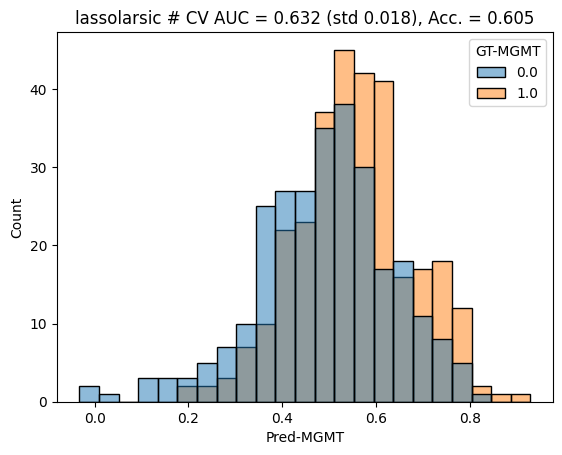

CV AUC = 0.6317709085656507 (std 0.01818126789005147), Acc. = 0.6048526863084922, aucs: [0.6017595307917889, 0.6568914956011731, 0.6301452784503632, 0.6393939393939394, 0.6407523510971787], accs: [0.5897435897435898, 0.6239316239316239, 0.5826086956521739, 0.6086956521739131, 0.6194690265486725]


0.6135896406755992

In [57]:
selected_features = [
    "mesh_volume",
    "sphericity",
    "maximum_2d_diameter_column",
    "maximum_2d_diameter_row",
    "elongation",
    "energy_0",
    "median_0",
    "robust_mean_abs_dev_0",
    "uniformity_0",
    "total_energy_1",
    "maximum_1",
    "median_1",
    "robust_mean_abs_dev_1",
    "uniformity_1",
    "median_2",
    "skewness_2",
    "kurtosis_2",
    "uniformity_2",
    "cluster_shade_0",
    "cluster_tendency_0",
    "correlation_0",
    "difference_entropy_0",
    "difference_variance_0",
    "joint_entropy_0",
    "autocorrelation_1",
    "joint_avg_1",
    "contrast_1",
    "cluster_prominence_1",
    "cluster_tendency_1",
    "difference_variance_1",
    "joint_avg_2",
    "cluster_tendency_2",
    "correlation_2",
    "difference_average_2",
    "difference_entropy_2",
    "difference_variance_2",
    "joint_energy_2",
    "joint_entropy_2",
    "minimum_ax_0",
    "percentile10_ax_0",
    "mean_ax_0",
    "median_ax_0",
    "percentile90_ax_0",
    "maximum_ax_0",
    "minimum_ax_1",
    "percentile10_ax_1",
    "mean_ax_1",
    "median_ax_1",
    "minimum_ax_2",
    "median_ax_2",
]

feature_pruned_parameters = {
    'model_type': 'lassolarsic',
    'n_estimators': 245,
    'max_depth' : 4,
    'eta': 0.12309061558731829,
    'subsample': 0.9927722396906344,
    'colsample_bytree' : 0.6198696510524733,
    'gamma' : 1.8267387708396023,
    'alpha' : 2.50433689492789,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : selected_features
}
tuned_lassolarsic_parameters = feature_pruned_parameters.copy()
measure_cv_score(tuned_lassolarsic_parameters, verbose=True, plot=True)

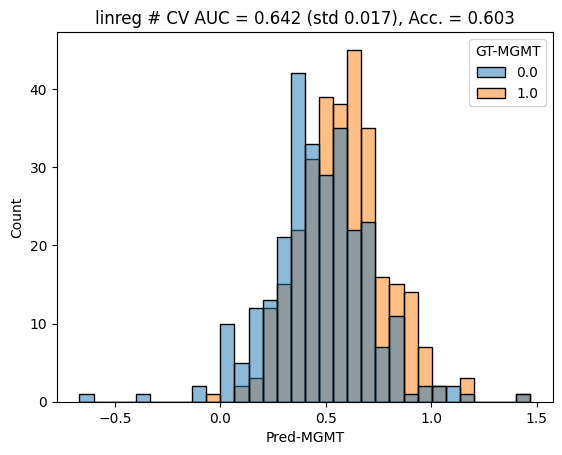

CV AUC = 0.6417015744619385 (std 0.01703785674394787), Acc. = 0.6031195840554593, aucs: [0.6173020527859238, 0.670674486803519, 0.6425544794188862, 0.6475757575757576, 0.6404388714733542], accs: [0.5726495726495726, 0.6410256410256411, 0.6, 0.5826086956521739, 0.6194690265486725]


0.6246637177179907

In [58]:
tuned_linreg_parameters = {
    'model_type': 'linreg',
    'n_estimators': 245,
    'max_depth' : 4,
    'eta': 0.12309061558731829,
    'subsample': 0.9927722396906344,
    'colsample_bytree' : 0.6198696510524733,
    'gamma' : 1.8267387708396023,
    'alpha' : 2.50433689492789,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : selected_features
}
measure_cv_score(tuned_linreg_parameters, verbose=True, plot=True)

In [66]:
def feat_selection_linreg_objective(trial):
    kept_feats = []
    for i in range(len(all_feat_names)):
        var = trial.suggest_int(all_feat_names[i], 0,1)
        if var == 1:
            kept_feats.append(all_feat_names[i])
    parameters = tuned_linreg_parameters.copy()
    parameters['features'] = kept_feats
    
    return 1 - measure_cv_score(parameters, verbose=False)

if 1:
    study = optuna.create_study()
    study.optimize(feat_selection_linreg_objective, n_trials=1000, show_progress_bar=True)
    print(study.best_value, study.best_params)

[I 2021-09-25 12:59:47,929] A new study created in memory with name: no-name-08c489fc-de4e-43ad-bc53-d9a010c9ad6f
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2021-09-25 12:59:48,029] Trial 0 finished with value: 0.4233246712775497 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minimu

[I 2021-09-25 12:59:48,274] Trial 4 finished with value: 0.46237690696503675 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'minim

[I 2021-09-25 12:59:48,526] Trial 8 finished with value: 0.3958615376864155 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'minimu

[I 2021-09-25 12:59:49,745] Trial 12 finished with value: 0.4264510293980641 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 12:59:51,314] Trial 16 finished with value: 0.4474587732321985 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 12:59:52,963] Trial 20 finished with value: 0.4445696780118884 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-25 12:59:54,622] Trial 24 finished with value: 0.4032779191734337 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 12:59:56,223] Trial 28 finished with value: 0.4394788722212357 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 12:59:57,820] Trial 32 finished with value: 0.4011174964672727 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 12:59:59,435] Trial 36 finished with value: 0.4106858404057965 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 13:00:01,127] Trial 40 finished with value: 0.4569232499334245 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 13:00:02,784] Trial 44 finished with value: 0.39880811209458134 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 13:00:04,434] Trial 48 finished with value: 0.44413471691485085 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:00:06,068] Trial 52 finished with value: 0.40255134073255494 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:00:07,745] Trial 56 finished with value: 0.4089519522259807 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:00:09,467] Trial 60 finished with value: 0.4017212395088081 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:00:11,160] Trial 64 finished with value: 0.4017371259321125 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:00:12,846] Trial 68 finished with value: 0.400387435032439 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minimu

[I 2021-09-25 13:00:14,509] Trial 72 finished with value: 0.4030605638686924 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:00:16,242] Trial 76 finished with value: 0.40622288201018886 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:00:17,977] Trial 80 finished with value: 0.40061812846287614 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:00:19,739] Trial 84 finished with value: 0.3983521675426437 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:00:21,457] Trial 88 finished with value: 0.4006060103320075 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:00:23,228] Trial 92 finished with value: 0.38974181941765784 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:00:24,979] Trial 96 finished with value: 0.389379360851664 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'minimu

[I 2021-09-25 13:00:26,808] Trial 100 finished with value: 0.4011733754044403 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:00:28,576] Trial 104 finished with value: 0.3974451006161924 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:00:30,526] Trial 108 finished with value: 0.4320469913330448 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:00:32,428] Trial 112 finished with value: 0.38055710475446114 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:00:34,292] Trial 116 finished with value: 0.4148694270738458 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:00:36,139] Trial 120 finished with value: 0.38530581498739336 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:00:37,939] Trial 124 finished with value: 0.38530581498739336 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:00:39,881] Trial 128 finished with value: 0.39314042502027846 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:00:41,753] Trial 132 finished with value: 0.38333738568222697 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:00:43,599] Trial 136 finished with value: 0.38333738568222697 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:00:45,763] Trial 140 finished with value: 0.39108246478430186 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:00:47,644] Trial 144 finished with value: 0.3806205292202639 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:00:49,556] Trial 148 finished with value: 0.38622161054959514 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:00:51,430] Trial 152 finished with value: 0.38077892062924823 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:00:53,404] Trial 156 finished with value: 0.3823178896999271 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:00:55,347] Trial 160 finished with value: 0.40334295674380816 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:00:57,224] Trial 164 finished with value: 0.38077892062924823 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:00:59,214] Trial 168 finished with value: 0.38077892062924823 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:01,159] Trial 172 finished with value: 0.3757129168706367 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:01:03,165] Trial 176 finished with value: 0.3801512512271601 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:01:05,146] Trial 180 finished with value: 0.3802396560204414 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:01:07,104] Trial 184 finished with value: 0.38024567460583314 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:09,054] Trial 188 finished with value: 0.37810742052545065 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:10,967] Trial 192 finished with value: 0.3777396994936656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:01:12,987] Trial 196 finished with value: 0.3777396994936656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:01:15,010] Trial 200 finished with value: 0.3767539123856952 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:01:17,018] Trial 204 finished with value: 0.3767539123856952 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:01:18,999] Trial 208 finished with value: 0.39861817913137876 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:20,993] Trial 212 finished with value: 0.3767539123856952 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:01:23,122] Trial 216 finished with value: 0.38640370635484733 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:25,083] Trial 220 finished with value: 0.37793699979422846 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:27,162] Trial 224 finished with value: 0.39580473744644773 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:29,149] Trial 228 finished with value: 0.39811734508776764 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:31,109] Trial 232 finished with value: 0.37759350468226194 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:33,115] Trial 236 finished with value: 0.37278914146720554 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:35,123] Trial 240 finished with value: 0.37278914146720554 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:37,162] Trial 244 finished with value: 0.37518652594628454 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:39,216] Trial 248 finished with value: 0.37518652594628454 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:41,242] Trial 252 finished with value: 0.37518652594628454 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:43,293] Trial 256 finished with value: 0.37518652594628454 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:45,314] Trial 260 finished with value: 0.37518652594628454 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:47,391] Trial 264 finished with value: 0.37518652594628454 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:49,481] Trial 268 finished with value: 0.3936493086587436 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:01:51,578] Trial 272 finished with value: 0.3760872971301865 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:01:53,655] Trial 276 finished with value: 0.37489295464674544 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:01:55,692] Trial 280 finished with value: 0.3763600117448612 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:01:57,797] Trial 284 finished with value: 0.38174938608314823 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:02:00,027] Trial 288 finished with value: 0.379366508061752 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'minim

[I 2021-09-25 13:02:02,219] Trial 292 finished with value: 0.37489295464674544 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:02:04,344] Trial 296 finished with value: 0.37489295464674544 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:02:06,445] Trial 300 finished with value: 0.38350830593210206 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:02:08,681] Trial 304 finished with value: 0.38331994472872755 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:02:10,806] Trial 308 finished with value: 0.37489295464674544 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:02:13,192] Trial 312 finished with value: 0.39080580802886566 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:02:15,433] Trial 316 finished with value: 0.38535107880443975 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:02:17,629] Trial 320 finished with value: 0.39215144607484786 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:02:19,851] Trial 324 finished with value: 0.3924428003563506 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:02:22,109] Trial 328 finished with value: 0.3742668411114142 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:02:24,369] Trial 332 finished with value: 0.3742668411114142 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:02:26,650] Trial 336 finished with value: 0.3742548039406307 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:02:28,807] Trial 340 finished with value: 0.3742548039406307 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:02:31,133] Trial 344 finished with value: 0.3742668411114142 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:02:33,498] Trial 348 finished with value: 0.3971178305066495 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:02:35,825] Trial 352 finished with value: 0.38698382032080103 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:02:38,185] Trial 356 finished with value: 0.3761638636948266 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:02:40,461] Trial 360 finished with value: 0.39771089498535017 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:02:42,769] Trial 364 finished with value: 0.387863515051583 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-25 13:02:45,161] Trial 368 finished with value: 0.3856478271728697 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:02:47,528] Trial 372 finished with value: 0.373785125459694 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'minim

[I 2021-09-25 13:02:49,744] Trial 376 finished with value: 0.37260979545211304 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:02:51,985] Trial 380 finished with value: 0.3743529465199712 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:02:54,221] Trial 384 finished with value: 0.3731553939967762 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:02:56,497] Trial 388 finished with value: 0.3731553939967762 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:02:58,747] Trial 392 finished with value: 0.38491692820170065 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:03:00,984] Trial 396 finished with value: 0.37314335682599287 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:03:03,226] Trial 400 finished with value: 0.39740343387534705 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:03:05,449] Trial 404 finished with value: 0.3797400154928019 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:07,713] Trial 408 finished with value: 0.36996751826387686 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:03:09,999] Trial 412 finished with value: 0.3723059760411439 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:12,274] Trial 416 finished with value: 0.3793616276775277 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:14,587] Trial 420 finished with value: 0.3723059760411439 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:16,904] Trial 424 finished with value: 0.3723059760411439 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:19,235] Trial 428 finished with value: 0.38651847280172746 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:03:21,536] Trial 432 finished with value: 0.3785783710658952 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:23,905] Trial 436 finished with value: 0.3723059760411439 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:26,229] Trial 440 finished with value: 0.3952301958839092 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:28,531] Trial 444 finished with value: 0.38094781058447114 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:03:30,855] Trial 448 finished with value: 0.3723059760411439 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:33,181] Trial 452 finished with value: 0.3723059760411439 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:35,530] Trial 456 finished with value: 0.3723059760411439 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:37,866] Trial 460 finished with value: 0.3723059760411439 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:40,202] Trial 464 finished with value: 0.38194921799699155 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:03:42,603] Trial 468 finished with value: 0.37217417032687516 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:03:45,052] Trial 472 finished with value: 0.3764635761897507 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:47,524] Trial 476 finished with value: 0.37154449130193623 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:03:49,937] Trial 480 finished with value: 0.37154449130193623 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:03:52,371] Trial 484 finished with value: 0.40850714050105186 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:03:54,917] Trial 488 finished with value: 0.3715324541311529 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:57,325] Trial 492 finished with value: 0.3715565284727196 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:03:59,736] Trial 496 finished with value: 0.3715565284727196 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:04:02,177] Trial 500 finished with value: 0.3715565284727196 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:04:04,666] Trial 504 finished with value: 0.373288991694256 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'minim

[I 2021-09-25 13:04:07,160] Trial 508 finished with value: 0.3715565284727196 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:04:09,628] Trial 512 finished with value: 0.3801193805245109 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:04:12,099] Trial 516 finished with value: 0.3715565284727196 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:04:14,615] Trial 520 finished with value: 0.39229944286797036 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:04:17,098] Trial 524 finished with value: 0.38310349646065844 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:04:19,652] Trial 528 finished with value: 0.3715565284727196 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:04:22,235] Trial 532 finished with value: 0.37154449130193623 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:04:24,709] Trial 536 finished with value: 0.37122759998471244 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:04:27,339] Trial 540 finished with value: 0.3746442919180446 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:04:29,969] Trial 544 finished with value: 0.37122759998471244 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:04:32,593] Trial 548 finished with value: 0.371215562813929 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'minim

[I 2021-09-25 13:04:35,154] Trial 552 finished with value: 0.3812225071646055 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:04:37,911] Trial 556 finished with value: 0.38328786889243527 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:04:40,656] Trial 560 finished with value: 0.3949656438727427 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:04:43,418] Trial 564 finished with value: 0.3712396371554957 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:04:46,194] Trial 568 finished with value: 0.37122759998471244 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:04:49,041] Trial 572 finished with value: 0.371215562813929 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'minim

[I 2021-09-25 13:04:51,700] Trial 576 finished with value: 0.37122759998471244 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:04:54,330] Trial 580 finished with value: 0.3896468999005521 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:04:56,995] Trial 584 finished with value: 0.3712432382636045 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:04:59,685] Trial 588 finished with value: 0.39394735657977986 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:05:02,371] Trial 592 finished with value: 0.41076885162441534 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:05:04,970] Trial 596 finished with value: 0.3709127831845864 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:05:07,549] Trial 600 finished with value: 0.4098463184716039 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:05:10,292] Trial 604 finished with value: 0.36881819406820116 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:05:13,134] Trial 608 finished with value: 0.3695566786564297 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:05:15,897] Trial 612 finished with value: 0.36809853612310384 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:05:18,750] Trial 616 finished with value: 0.37095176343732794 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:05:21,681] Trial 620 finished with value: 0.39687675408507994 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:05:24,873] Trial 624 finished with value: 0.368878833460741 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-25 13:05:28,038] Trial 628 finished with value: 0.39275724083766816 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:05:30,943] Trial 632 finished with value: 0.3979885187164991 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:05:33,851] Trial 636 finished with value: 0.38321560480407657 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:05:36,702] Trial 640 finished with value: 0.3728159973407772 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:05:39,684] Trial 644 finished with value: 0.36177367728351506 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:05:42,871] Trial 648 finished with value: 0.3695765860351665 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:05:45,961] Trial 652 finished with value: 0.3695765860351665 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:05:49,208] Trial 656 finished with value: 0.3695137510610257 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:05:52,504] Trial 660 finished with value: 0.3695137510610257 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:05:55,701] Trial 664 finished with value: 0.3923739413355892 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:05:58,968] Trial 668 finished with value: 0.3742621750667089 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:06:02,151] Trial 672 finished with value: 0.3743148006251743 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:06:05,106] Trial 676 finished with value: 0.37402404596251704 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:06:07,963] Trial 680 finished with value: 0.3695137510610257 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:06:10,958] Trial 684 finished with value: 0.3760413838090556 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:06:14,131] Trial 688 finished with value: 0.3695137510610257 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:06:17,152] Trial 692 finished with value: 0.3695137510610257 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:06:20,329] Trial 696 finished with value: 0.36253417925436615 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:06:23,277] Trial 700 finished with value: 0.38353816058663526 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:06:26,164] Trial 704 finished with value: 0.36938554551629155 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:06:29,103] Trial 708 finished with value: 0.37100009261761335 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 13:06:32,050] Trial 712 finished with value: 0.3849773281918172 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:06:35,094] Trial 716 finished with value: 0.36845902737077496 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:06:38,477] Trial 720 finished with value: 0.3889635706616512 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:06:41,835] Trial 724 finished with value: 0.3668551938893252 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:06:44,976] Trial 728 finished with value: 0.3680455146972753 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:06:48,082] Trial 732 finished with value: 0.3680173571623777 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:06:51,257] Trial 736 finished with value: 0.3680173571623777 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:06:54,186] Trial 740 finished with value: 0.3705016501439802 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:06:57,082] Trial 744 finished with value: 0.39897589997263105 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:07:00,065] Trial 748 finished with value: 0.36767991810550615 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:07:02,969] Trial 752 finished with value: 0.362219233985852 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-25 13:07:05,925] Trial 756 finished with value: 0.362219233985852 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-25 13:07:09,190] Trial 760 finished with value: 0.36270276715019 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minimu

[I 2021-09-25 13:07:12,504] Trial 764 finished with value: 0.36270276715019 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minimu

[I 2021-09-25 13:07:15,549] Trial 768 finished with value: 0.36270276715019 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minimu

[I 2021-09-25 13:07:18,697] Trial 772 finished with value: 0.3731889958671576 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:07:21,675] Trial 776 finished with value: 0.3597739188948925 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:07:24,962] Trial 780 finished with value: 0.3597739188948925 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:07:27,996] Trial 784 finished with value: 0.3772680439648698 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:07:31,091] Trial 788 finished with value: 0.36041044457573124 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:07:34,269] Trial 792 finished with value: 0.4009437104898944 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:07:37,564] Trial 796 finished with value: 0.37330070697543016 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:07:40,655] Trial 800 finished with value: 0.3631896893252342 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:07:44,000] Trial 804 finished with value: 0.3631896893252342 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:07:47,234] Trial 808 finished with value: 0.3631896893252342 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:07:50,541] Trial 812 finished with value: 0.37066569062666666 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:07:53,742] Trial 816 finished with value: 0.36920930726077983 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 13:07:56,989] Trial 820 finished with value: 0.37378460797255086 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:08:00,291] Trial 824 finished with value: 0.36141000497783937 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:08:03,348] Trial 828 finished with value: 0.3668257997270472 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:08:06,684] Trial 832 finished with value: 0.37423842921269357 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:08:09,815] Trial 836 finished with value: 0.3685570317668012 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:08:13,266] Trial 840 finished with value: 0.3621129137968113 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:08:16,411] Trial 844 finished with value: 0.36142094418799486 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:08:19,636] Trial 848 finished with value: 0.36746834124384387 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:08:22,782] Trial 852 finished with value: 0.3646077279655684 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:08:26,126] Trial 856 finished with value: 0.36594266071911175 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 13:08:29,291] Trial 860 finished with value: 0.3619681240899728 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:08:32,584] Trial 864 finished with value: 0.3606939381137816 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:08:35,851] Trial 868 finished with value: 0.36137706104533085 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:08:39,298] Trial 872 finished with value: 0.3591214671304521 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:08:42,550] Trial 876 finished with value: 0.4125943701526562 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:08:45,903] Trial 880 finished with value: 0.3591214671304521 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:08:49,343] Trial 884 finished with value: 0.36713680088332956 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:08:52,493] Trial 888 finished with value: 0.3631557313840228 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:08:56,163] Trial 892 finished with value: 0.36418769725886413 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:08:59,502] Trial 896 finished with value: 0.35921088206905005 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:09:02,980] Trial 900 finished with value: 0.35806788811869616 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:09:06,284] Trial 904 finished with value: 0.36659816801502176 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:09:09,746] Trial 908 finished with value: 0.35806788811869616 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:09:13,215] Trial 912 finished with value: 0.35806788811869616 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:09:16,678] Trial 916 finished with value: 0.3728441703097538 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:09:20,128] Trial 920 finished with value: 0.3557504235732034 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:09:23,706] Trial 924 finished with value: 0.35763308437814223 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:09:27,034] Trial 928 finished with value: 0.35763308437814223 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:09:30,484] Trial 932 finished with value: 0.3562353040979419 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:09:33,914] Trial 936 finished with value: 0.358600468314067 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 13:09:37,394] Trial 940 finished with value: 0.358600468314067 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-25 13:09:40,748] Trial 944 finished with value: 0.37348526352506517 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 13:09:44,175] Trial 948 finished with value: 0.35777244714365986 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 13:09:47,448] Trial 952 finished with value: 0.3577363830497997 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 13:09:50,862] Trial 956 finished with value: 0.3577363830497997 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 13:09:54,156] Trial 960 finished with value: 0.35780892106953055 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 13:09:57,590] Trial 964 finished with value: 0.3577363830497997 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 13:10:00,930] Trial 968 finished with value: 0.35780892106953055 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 13:10:04,396] Trial 972 finished with value: 0.36625394117074905 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 13:10:07,764] Trial 976 finished with value: 0.3577363830497997 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-25 13:10:11,223] Trial 980 finished with value: 0.37348526352506517 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 13:10:14,872] Trial 984 finished with value: 0.36971276862295677 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 13:10:18,278] Trial 988 finished with value: 0.40663134204496665 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 13:10:21,879] Trial 992 finished with value: 0.37266914133189555 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 13:10:25,350] Trial 996 finished with value: 0.35780892106953055 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'min

In [67]:
for name, sel in study.best_params.items():
    if sel == 1:
        print(f'"{name}",')

"spherical_disproportion",
"maximum_3d_diameter",
"least_axis_length",
"flatness",
"90percentile_0",
"kurtosis_0",
"uniformity_0",
"total_energy_1",
"10percentile_1",
"mean_1",
"median_1",
"robust_mean_abs_dev_1",
"skewness_1",
"maximum_2",
"mean_2",
"skewness_2",
"kurtosis_2",
"uniformity_2",
"autocorrelation_0",
"joint_avg_0",
"cluster_tendency_0",
"difference_average_0",
"difference_variance_0",
"joint_energy_0",
"autocorrelation_1",
"contrast_1",
"cluster_prominence_1",
"cluster_tendency_1",
"difference_average_1",
"autocorrelation_2",
"joint_avg_2",
"cluster_prominence_2",
"cluster_tendency_2",
"difference_average_2",
"joint_energy_2",
"minimum_ax_0",
"mean_ax_0",
"maximum_ax_0",
"minimum_ax_1",
"percentile10_ax_1",
"percentile90_ax_1",
"maximum_ax_1",
"median_ax_2",


In [77]:
selected_linreg_features = [
    "spherical_disproportion",
    "maximum_3d_diameter",
    "least_axis_length",
    "flatness",
    "90percentile_0",
    "kurtosis_0",
    "uniformity_0",
    "total_energy_1",
    "10percentile_1",
    "mean_1",
    "median_1",
    "robust_mean_abs_dev_1",
    "skewness_1",
    "maximum_2",
    "mean_2",
    "skewness_2",
    "kurtosis_2",
    "uniformity_2",
    "autocorrelation_0",
    "joint_avg_0",
    "cluster_tendency_0",
    "difference_average_0",
    "difference_variance_0",
    "joint_energy_0",
    "autocorrelation_1",
    "contrast_1",
    "cluster_prominence_1",
    "cluster_tendency_1",
    "difference_average_1",
    "autocorrelation_2",
    "joint_avg_2",
    "cluster_prominence_2",
    "cluster_tendency_2",
    "difference_average_2",
    "joint_energy_2",
    "minimum_ax_0",
    "mean_ax_0",
    "maximum_ax_0",
    "minimum_ax_1",
    "percentile10_ax_1",
    "percentile90_ax_1",
    "maximum_ax_1",
    "median_ax_2",
]

final_linreg_parameters = tuned_linreg_parameters.copy()
final_linreg_parameters['features'] = selected_linreg_features

measure_cv_score(final_linreg_parameters, verbose=True, plot=False)

CV AUC = 0.6479368289277287 (std 0.0036872525009322117), Acc. = 0.6377816291161178, aucs: [0.6457478005865103, 0.6448680351906159, 0.6540556900726393, 0.6436363636363637, 0.6460815047021944], accs: [0.6410256410256411, 0.6581196581196581, 0.6260869565217392, 0.6347826086956522, 0.6283185840707964]


0.6442495764267966

In [78]:
tuned_ridge_parameters = {
    'model_type': 'ridge',
    'n_estimators': 245,
    'max_depth' : 4,
    'eta': 0.12309061558731829,
    'subsample': 0.9927722396906344,
    'colsample_bytree' : 0.6198696510524733,
    'gamma' : 1.8267387708396023,
    'alpha' : 2.50433689492789,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : selected_features
}
measure_cv_score(tuned_ridge_parameters, verbose=True, plot=False)

CV AUC = 0.6402330396263661 (std 0.02073345267037972), Acc. = 0.6065857885615251, aucs: [0.6120234604105571, 0.6718475073313783, 0.6283292978208233, 0.6551515151515152, 0.6413793103448276], accs: [0.5897435897435898, 0.6410256410256411, 0.6347826086956522, 0.5652173913043478, 0.6017699115044248]


0.6194995869559864

In [79]:
def feat_selection_ridge_objective(trial):
    kept_feats = []
    for i in range(len(all_feat_names)):
        var = trial.suggest_int(all_feat_names[i], 0,1)
        if var == 1:
            kept_feats.append(all_feat_names[i])
    parameters = tuned_ridge_parameters.copy()
    parameters['features'] = kept_feats
    
    return 1 - measure_cv_score(parameters, verbose=False)

if 1:
    study = optuna.create_study()
    study.optimize(feat_selection_ridge_objective, n_trials=1000, show_progress_bar=True)
    print(study.best_value, study.best_params)

[I 2021-09-25 13:21:17,734] A new study created in memory with name: no-name-5cd911d6-944d-44f1-96d9-09e1556d3e52
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2021-09-25 13:21:17,846] Trial 0 finished with value: 0.4587111708235363 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'minimu

[I 2021-09-25 13:21:18,397] Trial 5 finished with value: 0.4307436659367698 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'minimu

[I 2021-09-25 13:21:19,245] Trial 10 finished with value: 0.43303662658427233 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:21:21,048] Trial 14 finished with value: 0.4096198655208887 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-25 13:21:22,762] Trial 18 finished with value: 0.39165247656331525 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:21:24,549] Trial 22 finished with value: 0.39165247656331525 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:21:26,388] Trial 26 finished with value: 0.39165247656331525 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:21:28,189] Trial 30 finished with value: 0.39165247656331525 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:21:30,046] Trial 34 finished with value: 0.39420098623262034 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:21:31,794] Trial 38 finished with value: 0.4218601622074417 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-25 13:21:33,718] Trial 42 finished with value: 0.3916404393925318 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-25 13:21:35,611] Trial 46 finished with value: 0.40627190032118565 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:21:37,651] Trial 50 finished with value: 0.40907624455180036 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:21:39,723] Trial 54 finished with value: 0.39165247656331525 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:21:42,043] Trial 58 finished with value: 0.4004128187488972 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-25 13:21:44,102] Trial 62 finished with value: 0.39021814279512534 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:21:45,993] Trial 66 finished with value: 0.38841398265342186 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:21:47,825] Trial 70 finished with value: 0.3972919628911704 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-25 13:21:49,718] Trial 74 finished with value: 0.38841398265342186 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:21:51,635] Trial 78 finished with value: 0.39820885306098275 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:21:53,511] Trial 82 finished with value: 0.3884260198242053 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-25 13:21:55,436] Trial 86 finished with value: 0.3903304093650599 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-25 13:21:57,406] Trial 90 finished with value: 0.377054034263269 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minimu

[I 2021-09-25 13:21:59,416] Trial 94 finished with value: 0.38490931477418033 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:22:01,406] Trial 98 finished with value: 0.412652464548357 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'minimu

[I 2021-09-25 13:22:03,497] Trial 102 finished with value: 0.3861196056261119 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-25 13:22:05,455] Trial 106 finished with value: 0.38251490524590426 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-25 13:22:07,420] Trial 110 finished with value: 0.39280592108520895 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:22:09,325] Trial 114 finished with value: 0.38269075547205855 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:22:11,319] Trial 118 finished with value: 0.4017073376258372 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:22:13,398] Trial 122 finished with value: 0.38462093490727933 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:22:15,370] Trial 126 finished with value: 0.3809854807287536 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:22:17,382] Trial 130 finished with value: 0.3825892534797257 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:22:19,355] Trial 134 finished with value: 0.38512964548462547 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:22:21,294] Trial 138 finished with value: 0.3791463558032646 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:22:23,282] Trial 142 finished with value: 0.3791463558032646 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:22:25,276] Trial 146 finished with value: 0.3705562117102438 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:22:27,284] Trial 150 finished with value: 0.3705562117102438 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:22:29,349] Trial 154 finished with value: 0.3705562117102438 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:22:31,409] Trial 158 finished with value: 0.37382242444123226 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:22:33,467] Trial 162 finished with value: 0.37124479727435844 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:22:35,542] Trial 166 finished with value: 0.39525910401517306 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:22:37,641] Trial 170 finished with value: 0.37903227811720375 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:22:39,693] Trial 174 finished with value: 0.36943234060088703 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:22:41,802] Trial 178 finished with value: 0.37320105485208543 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:22:43,889] Trial 182 finished with value: 0.37060803568958245 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:22:45,980] Trial 186 finished with value: 0.36879924368068673 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:22:48,047] Trial 190 finished with value: 0.3677105110549185 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:22:50,136] Trial 194 finished with value: 0.367698473884135 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'minim

[I 2021-09-25 13:22:52,203] Trial 198 finished with value: 0.38094560115623033 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:22:54,331] Trial 202 finished with value: 0.3682573734867921 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:22:56,450] Trial 206 finished with value: 0.3682573734867921 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:22:58,568] Trial 210 finished with value: 0.3710432547068707 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:23:00,793] Trial 214 finished with value: 0.36849138473305587 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:02,864] Trial 218 finished with value: 0.36849138473305587 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:05,092] Trial 222 finished with value: 0.36849138473305587 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:07,236] Trial 226 finished with value: 0.36849138473305587 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:09,432] Trial 230 finished with value: 0.3981931978319214 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:23:11,612] Trial 234 finished with value: 0.36849138473305587 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:13,812] Trial 238 finished with value: 0.36849138473305587 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:15,950] Trial 242 finished with value: 0.36849138473305587 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:18,105] Trial 246 finished with value: 0.3686988152240681 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:23:20,283] Trial 250 finished with value: 0.36754682522156346 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:22,383] Trial 254 finished with value: 0.3765692976387264 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:23:24,620] Trial 258 finished with value: 0.36595166565501025 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:26,810] Trial 262 finished with value: 0.36529202768883295 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:29,045] Trial 266 finished with value: 0.39823414065259033 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:31,259] Trial 270 finished with value: 0.36079952543478067 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:33,483] Trial 274 finished with value: 0.3616148001204167 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:23:35,716] Trial 278 finished with value: 0.3719210568017741 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:23:37,946] Trial 282 finished with value: 0.3741364075627688 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:23:40,155] Trial 286 finished with value: 0.3652434302920309 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:23:42,447] Trial 290 finished with value: 0.36872528446520614 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:44,644] Trial 294 finished with value: 0.3709259832060062 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:23:46,917] Trial 298 finished with value: 0.3668232439244018 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:23:49,226] Trial 302 finished with value: 0.3773478480814402 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:23:51,496] Trial 306 finished with value: 0.36709665823559445 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:23:53,775] Trial 310 finished with value: 0.3661280039176801 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:23:56,056] Trial 314 finished with value: 0.3661280039176801 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-25 13:23:58,374] Trial 318 finished with value: 0.36507925240695327 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-25 13:24:00,737] Trial 322 finished with value: 0.3761257847357591 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:24:03,087] Trial 326 finished with value: 0.3680292702516258 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:24:05,443] Trial 330 finished with value: 0.36766197935269596 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:24:07,770] Trial 334 finished with value: 0.36503692814464805 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:24:10,128] Trial 338 finished with value: 0.36503692814464805 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:24:12,489] Trial 342 finished with value: 0.36859507197292696 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:24:14,806] Trial 346 finished with value: 0.36591752237913455 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:24:17,174] Trial 350 finished with value: 0.4048270120634361 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:24:19,563] Trial 354 finished with value: 0.36503692814464805 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:24:21,949] Trial 358 finished with value: 0.3778951543476682 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:24:24,315] Trial 362 finished with value: 0.38497948478686717 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:24:26,696] Trial 366 finished with value: 0.37058965859200743 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:24:29,094] Trial 370 finished with value: 0.36503692814464805 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:24:31,480] Trial 374 finished with value: 0.3778367908487651 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:24:33,968] Trial 378 finished with value: 0.3647809529805649 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:24:36,376] Trial 382 finished with value: 0.38285249102755925 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:24:38,798] Trial 386 finished with value: 0.37557210247622463 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:24:41,219] Trial 390 finished with value: 0.3647809529805649 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:24:43,638] Trial 394 finished with value: 0.3647809529805649 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:24:46,103] Trial 398 finished with value: 0.3741081198467924 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:24:48,550] Trial 402 finished with value: 0.4002219870048741 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:24:51,058] Trial 406 finished with value: 0.3679477171101587 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:24:53,559] Trial 410 finished with value: 0.3647599449724118 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:24:56,021] Trial 414 finished with value: 0.3647599449724118 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:24:58,493] Trial 418 finished with value: 0.3647599449724118 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:00,936] Trial 422 finished with value: 0.3753111864070007 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:03,410] Trial 426 finished with value: 0.3686603248288216 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:05,949] Trial 430 finished with value: 0.3669813930168815 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:08,460] Trial 434 finished with value: 0.3654178061595639 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:10,938] Trial 438 finished with value: 0.3634489090907277 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:13,486] Trial 442 finished with value: 0.36463582412093176 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:25:15,988] Trial 446 finished with value: 0.36463582412093176 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:25:18,663] Trial 450 finished with value: 0.3713423696386151 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:21,297] Trial 454 finished with value: 0.36463582412093176 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:25:23,940] Trial 458 finished with value: 0.3620115030421348 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:26,513] Trial 462 finished with value: 0.3699988086281384 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:29,036] Trial 466 finished with value: 0.36321661122149695 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:25:31,596] Trial 470 finished with value: 0.36369867982398163 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:25:34,164] Trial 474 finished with value: 0.36369867982398163 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:25:36,685] Trial 478 finished with value: 0.3888209600350774 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:39,243] Trial 482 finished with value: 0.37378698094744855 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:25:41,894] Trial 486 finished with value: 0.36359816212518203 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:25:44,649] Trial 490 finished with value: 0.3609717522743138 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:47,271] Trial 494 finished with value: 0.3609717522743138 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:49,861] Trial 498 finished with value: 0.3609717522743138 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:52,471] Trial 502 finished with value: 0.3722648062245868 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:25:55,095] Trial 506 finished with value: 0.36378512086288994 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:25:57,743] Trial 510 finished with value: 0.3609717522743138 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:00,386] Trial 514 finished with value: 0.3609717522743138 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:03,024] Trial 518 finished with value: 0.3716840797627825 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:05,676] Trial 522 finished with value: 0.3609717522743138 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:08,381] Trial 526 finished with value: 0.37243774081391434 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:26:11,140] Trial 530 finished with value: 0.36931587613788575 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:26:13,979] Trial 534 finished with value: 0.3764934913335718 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:16,832] Trial 538 finished with value: 0.3609717522743138 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:19,719] Trial 542 finished with value: 0.3736187725402649 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:22,519] Trial 546 finished with value: 0.3609717522743138 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:25,226] Trial 550 finished with value: 0.36738545918903165 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:26:27,921] Trial 554 finished with value: 0.3609717522743138 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:30,666] Trial 558 finished with value: 0.3664340762768932 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:33,419] Trial 562 finished with value: 0.3793884752214194 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:36,166] Trial 566 finished with value: 0.370759458638686 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:26:38,977] Trial 570 finished with value: 0.36339067579810036 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:26:41,699] Trial 574 finished with value: 0.3605858111621223 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:44,461] Trial 578 finished with value: 0.3698772246531451 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:47,209] Trial 582 finished with value: 0.37303053654635787 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:26:49,985] Trial 586 finished with value: 0.3705262789600203 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:52,755] Trial 590 finished with value: 0.3605858111621223 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:55,500] Trial 594 finished with value: 0.3605858111621223 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:26:58,268] Trial 598 finished with value: 0.3605858111621223 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:01,098] Trial 602 finished with value: 0.37294341873553427 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:27:03,913] Trial 606 finished with value: 0.37724460019679784 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:27:06,742] Trial 610 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:09,532] Trial 614 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:12,365] Trial 618 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:15,209] Trial 622 finished with value: 0.37043439652468735 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:27:18,047] Trial 626 finished with value: 0.3866278002209107 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:21,041] Trial 630 finished with value: 0.36888573201185915 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:27:23,945] Trial 634 finished with value: 0.3620715604602909 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:26,933] Trial 638 finished with value: 0.3746234056587685 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:29,783] Trial 642 finished with value: 0.3872693674926245 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:32,702] Trial 646 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:35,781] Trial 650 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:38,865] Trial 654 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:41,951] Trial 658 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:45,065] Trial 662 finished with value: 0.3624049253563528 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:48,434] Trial 666 finished with value: 0.36265846323674467 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:27:51,525] Trial 670 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:54,497] Trial 674 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:27:57,606] Trial 678 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:00,540] Trial 682 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:03,690] Trial 686 finished with value: 0.37710701219798093 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:28:06,714] Trial 690 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:09,788] Trial 694 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:12,836] Trial 698 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:15,842] Trial 702 finished with value: 0.3785784433997027 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:18,893] Trial 706 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:22,077] Trial 710 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:25,139] Trial 714 finished with value: 0.3729822261793406 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:28,274] Trial 718 finished with value: 0.36343589611595406 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:28:31,327] Trial 722 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:34,424] Trial 726 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:37,649] Trial 730 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:40,933] Trial 734 finished with value: 0.36370085547769815 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'min

[I 2021-09-25 13:28:44,242] Trial 738 finished with value: 0.3686310464513112 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:47,300] Trial 742 finished with value: 0.36130819861287056 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:28:50,386] Trial 746 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:28:56,823] Trial 750 finished with value: 0.3634429247714308 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:29:00,276] Trial 754 finished with value: 0.39952312562620274 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:29:03,423] Trial 758 finished with value: 0.36343589611595406 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:29:06,638] Trial 762 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:29:09,859] Trial 766 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:29:13,110] Trial 770 finished with value: 0.3624188456593821 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:29:16,282] Trial 774 finished with value: 0.370422359353904 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:29:20,062] Trial 778 finished with value: 0.3762146187482974 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:29:23,298] Trial 782 finished with value: 0.3625877153904935 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:29:26,502] Trial 786 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:29:29,761] Trial 790 finished with value: 0.37192402412428704 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:29:32,966] Trial 794 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:29:36,154] Trial 798 finished with value: 0.3606054325595581 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:29:39,384] Trial 802 finished with value: 0.3605858111621223 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:29:43,166] Trial 806 finished with value: 0.36046616562104183 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:29:46,497] Trial 810 finished with value: 0.37958547331273385 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:29:49,830] Trial 814 finished with value: 0.36435210700886367 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:29:53,153] Trial 818 finished with value: 0.381044578390641 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:29:56,416] Trial 822 finished with value: 0.3605858111621223 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:29:59,766] Trial 826 finished with value: 0.3628502874752645 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:30:03,661] Trial 830 finished with value: 0.3707917308600919 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:30:06,978] Trial 834 finished with value: 0.36867704495792997 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:30:10,305] Trial 838 finished with value: 0.37127623869798065 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:30:13,597] Trial 842 finished with value: 0.3602692891961071 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:30:16,845] Trial 846 finished with value: 0.38494557032073495 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:30:20,210] Trial 850 finished with value: 0.3706014066116434 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:30:24,113] Trial 854 finished with value: 0.369480352148407 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:30:27,491] Trial 858 finished with value: 0.3796835837133302 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:30:30,864] Trial 862 finished with value: 0.37486507172961303 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:30:34,205] Trial 866 finished with value: 0.3607482413043347 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:30:37,586] Trial 870 finished with value: 0.37281695610079413 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:30:41,083] Trial 874 finished with value: 0.4083369789233857 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:30:45,175] Trial 878 finished with value: 0.36573459176528855 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:30:48,705] Trial 882 finished with value: 0.37978727550669034 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:30:52,148] Trial 886 finished with value: 0.37051774588198294 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:30:55,710] Trial 890 finished with value: 0.360332200098161 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:30:59,176] Trial 894 finished with value: 0.3640478398109186 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:31:02,689] Trial 898 finished with value: 0.3603442372689444 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:31:06,779] Trial 902 finished with value: 0.4052900362448869 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:31:10,638] Trial 906 finished with value: 0.3651471685571016 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:31:14,258] Trial 910 finished with value: 0.360332200098161 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:31:17,809] Trial 914 finished with value: 0.3636956035341057 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:31:21,245] Trial 918 finished with value: 0.3953078460951809 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:31:24,741] Trial 922 finished with value: 0.3707217295043005 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:31:28,773] Trial 926 finished with value: 0.360332200098161 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:31:32,357] Trial 930 finished with value: 0.37791544201042093 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:31:35,841] Trial 934 finished with value: 0.37954030539672734 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:31:39,354] Trial 938 finished with value: 0.3749953512852756 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:31:42,861] Trial 942 finished with value: 0.360332200098161 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:31:46,341] Trial 946 finished with value: 0.37535269977500785 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:31:50,413] Trial 950 finished with value: 0.36378307160133694 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:31:54,049] Trial 954 finished with value: 0.3738004545712008 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:31:57,648] Trial 958 finished with value: 0.3673293913366785 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:32:01,495] Trial 962 finished with value: 0.3905855660165509 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:32:05,346] Trial 966 finished with value: 0.3694064019814659 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:32:09,251] Trial 970 finished with value: 0.3677409556963285 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:32:13,172] Trial 974 finished with value: 0.3823400658728793 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:32:17,462] Trial 978 finished with value: 0.40714112261825464 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:32:21,179] Trial 982 finished with value: 0.36456134094031967 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:32:24,755] Trial 986 finished with value: 0.360332200098161 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

[I 2021-09-25 13:32:28,492] Trial 990 finished with value: 0.3666341687877068 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-25 13:32:32,050] Trial 994 finished with value: 0.37280731431647285 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-25 13:32:35,615] Trial 998 finished with value: 0.36573459176528855 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

In [80]:
for name, sel in study.best_params.items():
    if sel == 1:
        print(f'"{name}",')

"mesh_volume",
"surface_volume_ratio",
"maximum_3d_diameter",
"maximum_2d_diameter_column",
"maximum_2d_diameter_row",
"minor_axis_length",
"elongation",
"energy_0",
"entropy_0",
"minimum_0",
"mean_abs_dev_0",
"skewness_0",
"uniformity_0",
"energy_1",
"total_energy_1",
"maximum_1",
"mean_1",
"median_1",
"robust_mean_abs_dev_1",
"kurtosis_1",
"energy_2",
"total_energy_2",
"entropy_2",
"minimum_2",
"10percentile_2",
"90percentile_2",
"maximum_2",
"mean_abs_dev_2",
"robust_mean_abs_dev_2",
"kurtosis_2",
"contrast_0",
"correlation_0",
"difference_average_0",
"joint_entropy_0",
"autocorrelation_1",
"joint_avg_1",
"cluster_prominence_1",
"cluster_tendency_1",
"difference_average_1",
"difference_variance_1",
"joint_energy_1",
"joint_entropy_1",
"cluster_tendency_2",
"correlation_2",
"difference_entropy_2",
"difference_variance_2",
"maximum_ax_0",
"mean_ax_1",
"median_ax_2",


In [81]:
selected_ridge_features = [
    "mesh_volume",
    "surface_volume_ratio",
    "maximum_3d_diameter",
    "maximum_2d_diameter_column",
    "maximum_2d_diameter_row",
    "minor_axis_length",
    "elongation",
    "energy_0",
    "entropy_0",
    "minimum_0",
    "mean_abs_dev_0",
    "skewness_0",
    "uniformity_0",
    "energy_1",
    "total_energy_1",
    "maximum_1",
    "mean_1",
    "median_1",
    "robust_mean_abs_dev_1",
    "kurtosis_1",
    "energy_2",
    "total_energy_2",
    "entropy_2",
    "minimum_2",
    "10percentile_2",
    "90percentile_2",
    "maximum_2",
    "mean_abs_dev_2",
    "robust_mean_abs_dev_2",
    "kurtosis_2",
    "contrast_0",
    "correlation_0",
    "difference_average_0",
    "joint_entropy_0",
    "autocorrelation_1",
    "joint_avg_1",
    "cluster_prominence_1",
    "cluster_tendency_1",
    "difference_average_1",
    "difference_variance_1",
    "joint_energy_1",
    "joint_entropy_1",
    "cluster_tendency_2",
    "correlation_2",
    "difference_entropy_2",
    "difference_variance_2",
    "maximum_ax_0",
    "mean_ax_1",
    "median_ax_2",
]

final_ridge_parameters = tuned_ridge_parameters.copy()
final_ridge_parameters['features'] = selected_ridge_features

measure_cv_score(final_ridge_parameters, verbose=True, plot=False)

CV AUC = 0.6422432471471905 (std 0.002512536343297572), Acc. = 0.6048526863084922, aucs: [0.6419354838709677, 0.6460410557184751, 0.6398305084745763, 0.6436363636363637, 0.6391849529780564], accs: [0.5811965811965812, 0.6495726495726496, 0.6173913043478261, 0.5826086956521739, 0.5929203539823009]


0.6397307108038929

Models that perform well are LassoLarsIC, LinearRegression and RidgeRegression

## Ensemble of three models

In [89]:
val_preds, val_gts = [], []
for params in [tuned_lassolarsic_parameters, final_linreg_parameters, final_ridge_parameters]:
    val_pred, val_gt = measure_cv_score(params, return_oof_preds=True)
    val_preds.append(val_pred)
    val_gts.append(val_gt)
val_preds = np.mean(np.stack(val_preds), axis=0)
val_gts = np.mean(np.stack(val_gts), axis=0)

oof_acc = accuracy_score((np.array(val_gts) > 0.5).flatten(), (np.array(val_preds) > 0.5).flatten())
oof_auc = roc_auc_score(np.array(val_gts).flatten().astype(np.float32), np.array(val_preds).flatten())
print(f'acc {oof_acc}, auc {oof_auc}')

plt.close('all')
#df_plot = pd.DataFrame({'Pred-MGMT': val_preds, 'GT-MGMT': val_gts})
#sns.histplot(x='Pred-MGMT', hue='GT-MGMT', data=df_plot)
#plt.title(f'LassoLarsIC + LinReg + Ridge # CV AUC = {oof_auc:.3f}, Acc. = {oof_acc:.3f}')
#plt.show()

acc 0.6117850953206239, auc 0.6517526120660602


In [90]:
from joblib import dump, load
import json

save_dir = '../output/20210925_segmentation_feature_model_v3'
os.mkdir(save_dir)

for i, params in enumerate([tuned_lassolarsic_parameters, final_linreg_parameters, final_ridge_parameters]):
    model, scaler = measure_cv_score(params, train_one_model=True)
    model_fn = os.path.join(save_dir, f'feature_model_{i}.joblib')
    dump(model, model_fn)

    scaler_fn = os.path.join(save_dir, f'feature_model_scaler_{i}.joblib')
    dump(scaler, scaler_fn)

    param_fn = os.path.join(save_dir, f'params_{i}.json')
    with open(param_fn, 'w', encoding='utf-8') as f:
        json.dump(params, f, indent=4)